In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload


import pandas as pd
import sys
#import seaborn as sns
sys.path.append('../../src')
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter

from abrTools import loadKingsData, loadSheffieldData,interFunc

fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('../..','results',str(date.today()))

if not os.path.exists(savefolder):
    os.makedirs(savefolder)

from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=45
fontSize = 54*2
import matplotlib.gridspec as gridspec

resultFolder = '../../results/2024-10-27-sheffieldvKings-unscaled'
import figureTools

Using matplotlib backend: <object object at 0x1091be480>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def generateMaster(resultFolder,experiment='Sheffield'):
    master = at.collectResults(resultFolder,experiment,cvFoldColumn=True)

    master['accuracy'] = master['accuracy']*100
    master['test_precision_scorer_avg'] = master['test_precision_scorer_avg']*100
    master['test_recall_scorer_avg'] = master['test_recall_scorer_avg']*100
    master['roc_auc_score'] = master['roc_auc_score']*100
    master['test_precision_scorer_6N'] = master['test_precision_scorer_6N']*100
    master['test_recall_scorer_6N'] = master['test_recall_scorer_6N']*100
    master['test_f1_scorer_6N'] = master['test_f1_scorer_6N']*100

    master['test_precision_scorer_Rep'] = master['test_precision_scorer_Rep']*100
    master['test_recall_scorer_Rep'] = master['test_recall_scorer_Rep']*100
    master['test_f1_scorer_Rep'] = master['test_f1_scorer_Rep']*100
    
    master.loc[master['Model']=='HiveCote Anova FS','Model'] = 'HC'
    master.loc[master['Model']=='MLP Anova FS','Model'] = 'MLP'
    master.loc[master['Model']=='SVC Anova FS','Model'] = 'SVM'
    master.loc[master['Model']=='Random Forest Anova FS','Model'] = 'RF'
    master.loc[master['Model']=='Rocket Anova FS','Model'] = 'Rckt'
    master.loc[master['Model']=='XGBOOST Anova FS','Model'] = 'XGB'
    return master

In [3]:
masterSheffield = generateMaster(resultFolder,experiment='Sheffield')
masterKings = generateMaster(resultFolder,experiment='Kings')
masterCombined = generateMaster(resultFolder,experiment='Combined')

In [4]:
masterSheffield['Set'] = 'Set1'
masterKings['Set'] = 'Set2'
masterCombined['Set'] = 'Combined'

df = pd.concat((masterSheffield,masterKings,masterCombined))

In [5]:
df['Set'] = df['Set'].astype('category')
df['Model'] = df['Model'].astype('category')

In [6]:
df['Model'].unique()

['RF', 'SVM', 'XGB', 'Rckt', 'HC', 'MLP']
Categories (6, object): ['HC', 'MLP', 'RF', 'Rckt', 'SVM', 'XGB']

In [7]:
df['dataset_cv_split'] = df['Model'].astype(str) + '_' + df['CV_fold'].astype(str)


In [8]:
from statsmodels.formula.api import mixedlm

# Sample data frame structure
# df = pd.DataFrame({
#     'performance_metric': [0.85, 0.88, 0.90, ...],  # response variable
#     'model': ['RF', 'RF', 'SVM', ...],             # model factor
#     'dataset': ['primary', 'repeated', 'combined', ...],  # dataset factor
#     'cv_split': [1, 2, 3, ...]                      # CV split (random effect)
# })

# Fit the mixed-effects model
model = mixedlm("roc_auc_score ~ Model * C(Set, Treatment('Combined'))",  # model formula with interaction term
                df,
                groups=df["dataset_cv_split"])  # specify CV split as random effect

# Fit the model
mixed_model_result = model.fit()

# Print the results
print(mixed_model_result.summary())

                             Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             roc_auc_score
No. Observations:             450                 Method:                         REML         
No. Groups:                   150                 Scale:                          41.7770      
Min. group size:              3                   Log-Likelihood:                 -1465.6573   
Max. group size:              3                   Converged:                      Yes          
Mean group size:              3.0                                                              
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                           89.852    1.351 6

Results: 

Recall
set1_vs_combined = 0.439
set1_vs_set2 = 0.755
set2_vs_combined = 0.278

Sensitivity
set1_vs_combined = 0.373
set1_vs_set2 = 0.624
set2_vs_combined = 0.688

Precision
set1_vs_combined = 0.182
set1_vs_set2 = 0.468
set2_vs_combined = 0.542

Roc auc score
set1_vs_combined = 0.125
set1_vs_set2 = 0.700
set2_vs_combined = 0.251


In [9]:
df.groupby(['Model','Set'])[['test_recall_scorer_6N','test_recall_scorer_Rep','test_precision_scorer_6N','roc_auc_score','accuracy','test_f1_scorer_6N']].agg([mean,std]).to_clipboard()

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_92338/2906795831.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Model','Set'])[['test_recall_scorer_6N','test_recall_scorer_Rep','test_precision_scorer_6N','roc_auc_score','accuracy','test_f1_scorer_6N']].agg([mean,std]).to_clipboard()
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_92338/2906795831.py:1: FutureWarning: The provided callable <function mean at 0x109259750> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['Model','Set'])[['test_recall_scorer_6N','test_recall_scorer_Rep','test_precision_scorer_6N','roc_auc_score','accuracy','test_f1_scorer_6N']].agg([mean,std]).t

In [10]:
%%R -i df -o out2,out0,out1,out3,ss
res.aov <- aov(test_recall_scorer_6N ~ Model+Set, df) # 'accuracy', 'test_precision_scorer_avg',     'test_recall_scorer_avg', 'roc_auc_score'
ss <- summary(res.aov)

out2 <- as.data.frame(TukeyHSD(res.aov)[2])
out0 <- as.data.frame(TukeyHSD(res.aov)[0])
out1 <- as.data.frame(TukeyHSD(res.aov)[1])
out3 <- as.data.frame(TukeyHSD(res.aov)[3])

/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [11]:
ss

o{'None':                 Df        Sum Sq      Mean Sq   F value        Pr(>F)
Model          5.0   6471.535528  1294.307106  7.731590  5.500007e-07
Set            2.0   1971.268421   985.634210  5.887722  2.995455e-03
Residuals    442.0  73993.022925   167.405029       NaN           NaN, }

In [12]:
out2

Set.diff   Set.lwr   Set.upr  Set.p.adj
Set1-Combined  4.927444  1.414077  8.440811   0.003016
Set2-Combined  3.689654  0.176287  7.203021   0.036946
Set2-Set1     -1.237790 -4.751157  2.275577   0.685524

In [13]:
out3

Empty DataFrame
Columns: []
Index: []

In [14]:
from sklearn.preprocessing import LabelEncoder
def rand_jitter(arr):
    stdev = 0.04 #* (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def makeMetricFigure(df,metric='accuracy',le=None,ylabel='',figureSizeSF = [1,1],shift=0,ax=None,f=None,gs=None,color='k'):
    
    df2 = df.drop(['p_value','Frequency'],axis=1).groupby('Model')[[metric]].agg(('mean','std')).reset_index()
    if le is None:
        le = LabelEncoder()
        le.fit(df['Model'])
    df['Model idx'] = le.transform(df['Model'])
    df2['Model idx'] = le.transform(df2['Model'])

    if ax is None:
        f=plt.figure(figsize=(3.7*2.5*1.6138 * figureSizeSF[0],3.7*2.5*1.2* figureSizeSF[1]))
        gs= gridspec.GridSpec(1,1,hspace=0,figure=f)
        ax = plt.subplot(gs[0])
    jitterx = rand_jitter(df['Model idx'].values) +shift
    #sns.barplot(data=df,x='Model',y='accuracy',ax=ax,linewidth=3,ci='sd')
    #plt.bar(df2['Model idx'].values,df2[[('accuracy','mean')]].values.ravel())
    plt.scatter(jitterx,df[metric],s=markersize**1.85/2.5*np.mean(figureSizeSF),clip_on=False,alpha=0.2,linewidths=0)


    plt.errorbar(df2['Model idx'].values+shift,df2[[(metric,'mean')]].values.ravel(),df2[[(metric,'std')]].values.ravel(),fmt='o',markersize=markersize,clip_on=False,capsize=13,linewidth=4,capthick=4)
    #sns.swarmplot(data=df,x='Model',y='accuracy',ax=ax,linewidth=3)

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.set_xticks(np.arange(df2.shape[0]),le.inverse_transform(np.arange(6)),rotation=45)
    #ax.set_xlim(0,df2.shape[0]-1)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    ax.set_ylabel(ylabel)
    gs.tight_layout(f,rect=[0,0,1,0.95])
   # tight_layout()

    return ax,le,f,gs

In [15]:
masterSheffield

accuracy  test_f1_scorer_avg  test_f1_scorer_6N  test_f1_scorer_Rep  \
0    93.750000            0.937255          93.333333           94.117647   
1    87.500000            0.875000          87.500000           87.500000   
2    77.777778            0.742063          77.777778           71.428571   
3    47.321429            0.461905          50.000000           42.857143   
4    78.571429            0.788517          72.727273           84.210526   
..         ...                 ...                ...                 ...   
20  100.000000            1.000000         100.000000          100.000000   
21   87.500000            0.875000          87.500000           87.500000   
22   87.301587            0.875000          85.714286           88.888889   
23   58.928571            0.588889          50.000000           66.666667   
24   58.928571            0.588889          50.000000           66.666667   

    roc_auc_score  test_precision_scorer_avg  test_precision_scorer_6N  \
0       95.312500                  94.444444                100.000000   
1       93.750000                  87.500000                 87.500000   
2       91.269841                  84.090909                 63.636364   
3       67.857143                  47.407407                 44.444444   
4       92.857143                  85.454545                100.000000   
..            ...                        ...                       ...   
20     100.000000                 100.000000                100.000000   
21      84.375000                  87.500000                 87.500000   
22      98.412698                  87.500000                 85.714286   
23      73.214286                  60.000000                 60.000000   
24      73.214286                  60.000000                 60.000000   

    test_precision_scorer_Rep  test_recall_scorer_avg  test_recall_scorer_6N  \
0                   88.888889               93.750000              87.500000   
1                   87.500000               87.500000              87.500000   
2                  100.000000               75.000000             100.000000   
3                   50.000000               46.666667              57.142857   
4                   72.727273               80.000000              57.142857   
..                        ...                     ...                    ...   
20                 100.000000              100.000000             100.000000   
21                  87.500000               87.500000              87.500000   
22                  88.888889               87.500000              85.714286   
23                  60.000000               60.000000              42.857143   
24                  60.000000               60.000000              42.857143   

    test_recall_scorer_Rep  p_value Frequency Model  CV_fold   Set  
0               100.000000      NaN     Click    RF        1  Set1  
1                87.500000      NaN     Click    RF        2  Set1  
2                55.555556      NaN     Click    RF        3  Set1  
3                37.500000      NaN     Click    RF        4  Set1  
4               100.000000      NaN     Click    RF        5  Set1  
..                     ...      ...       ...   ...      ...   ...  
20              100.000000      NaN     Click   MLP       21  Set1  
21               87.500000      NaN     Click   MLP       22  Set1  
22               88.888889      NaN     Click   MLP       23  Set1  
23               75.000000      NaN     Click   MLP       24  Set1  
24               75.000000      NaN     Click   MLP       25  Set1  

[150 rows x 16 columns]

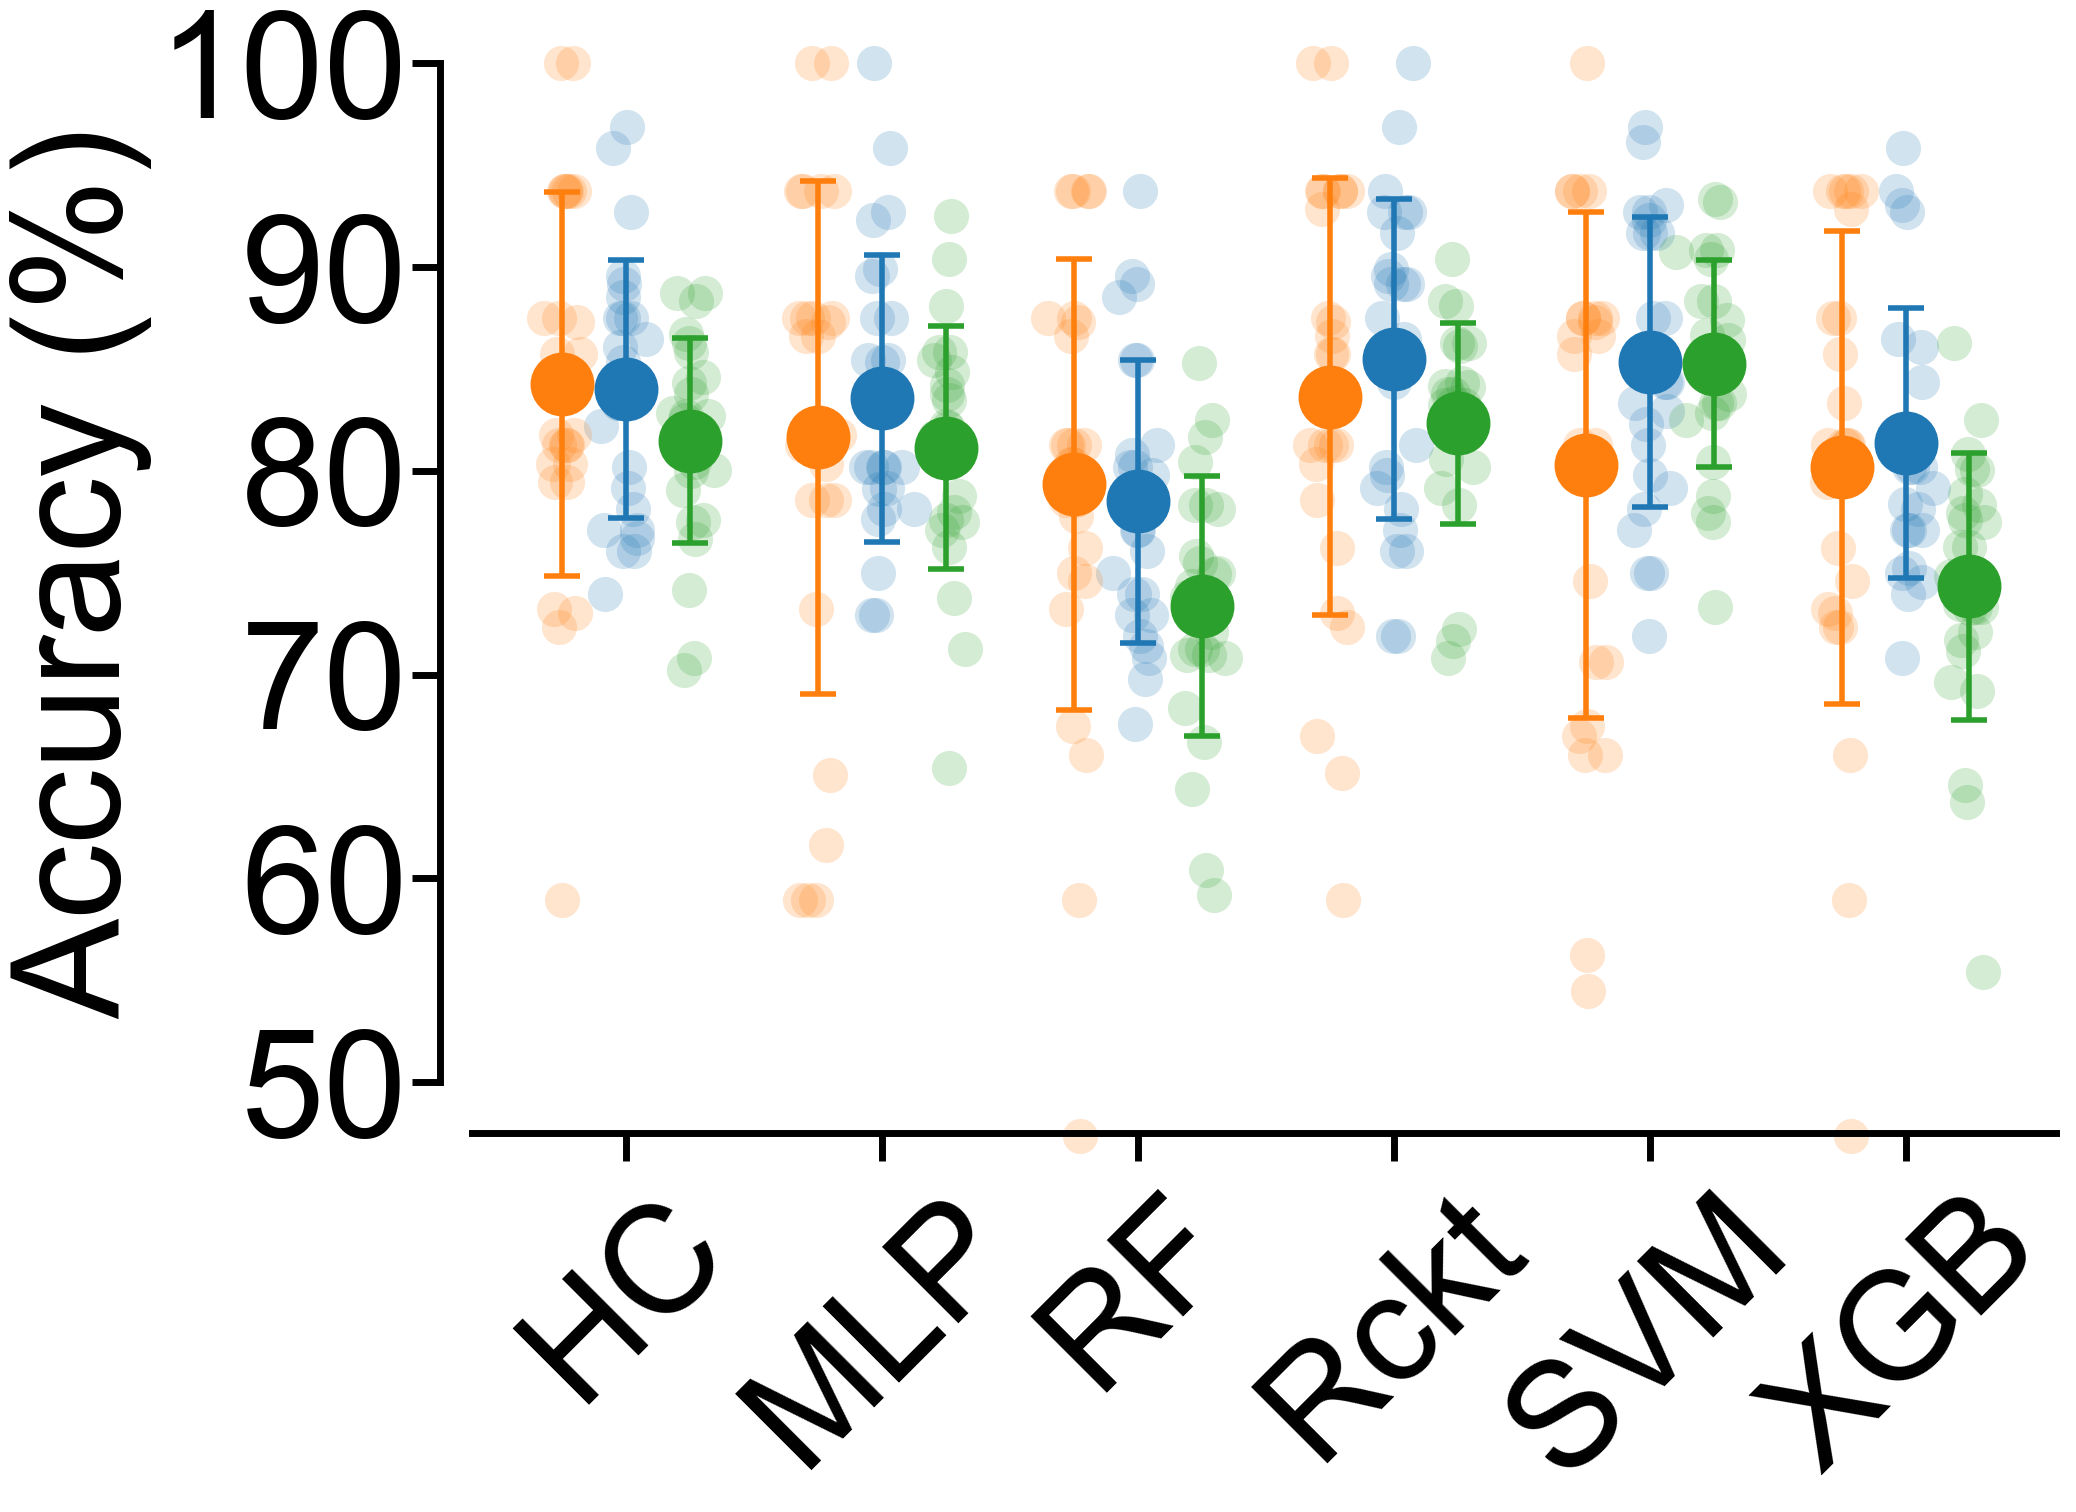

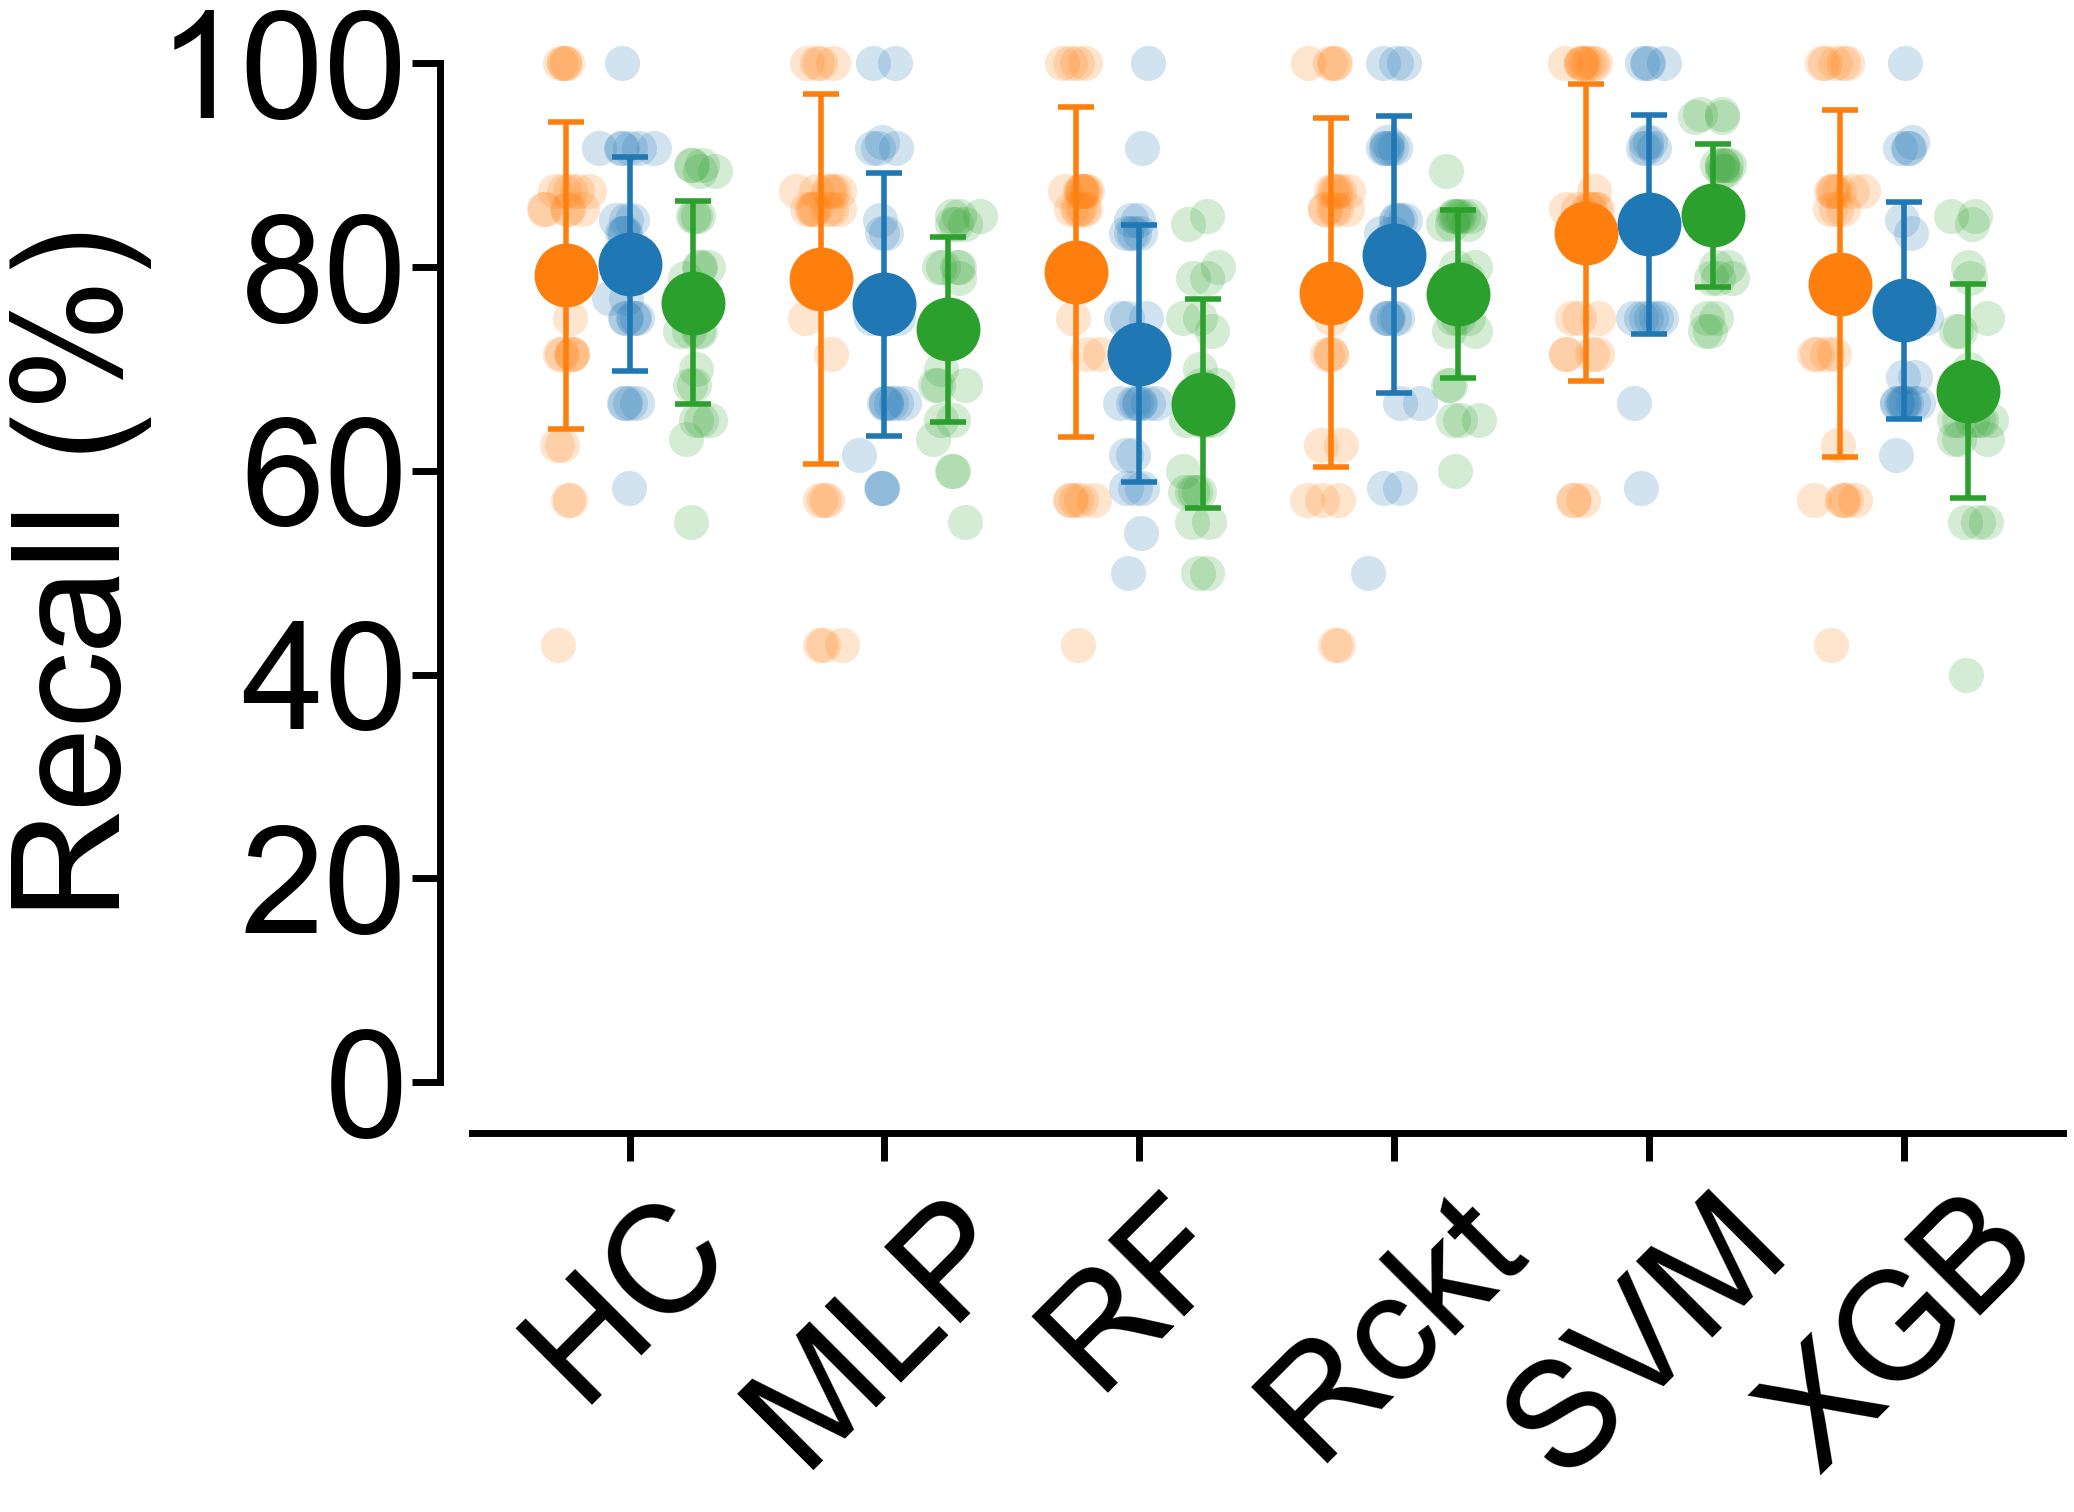

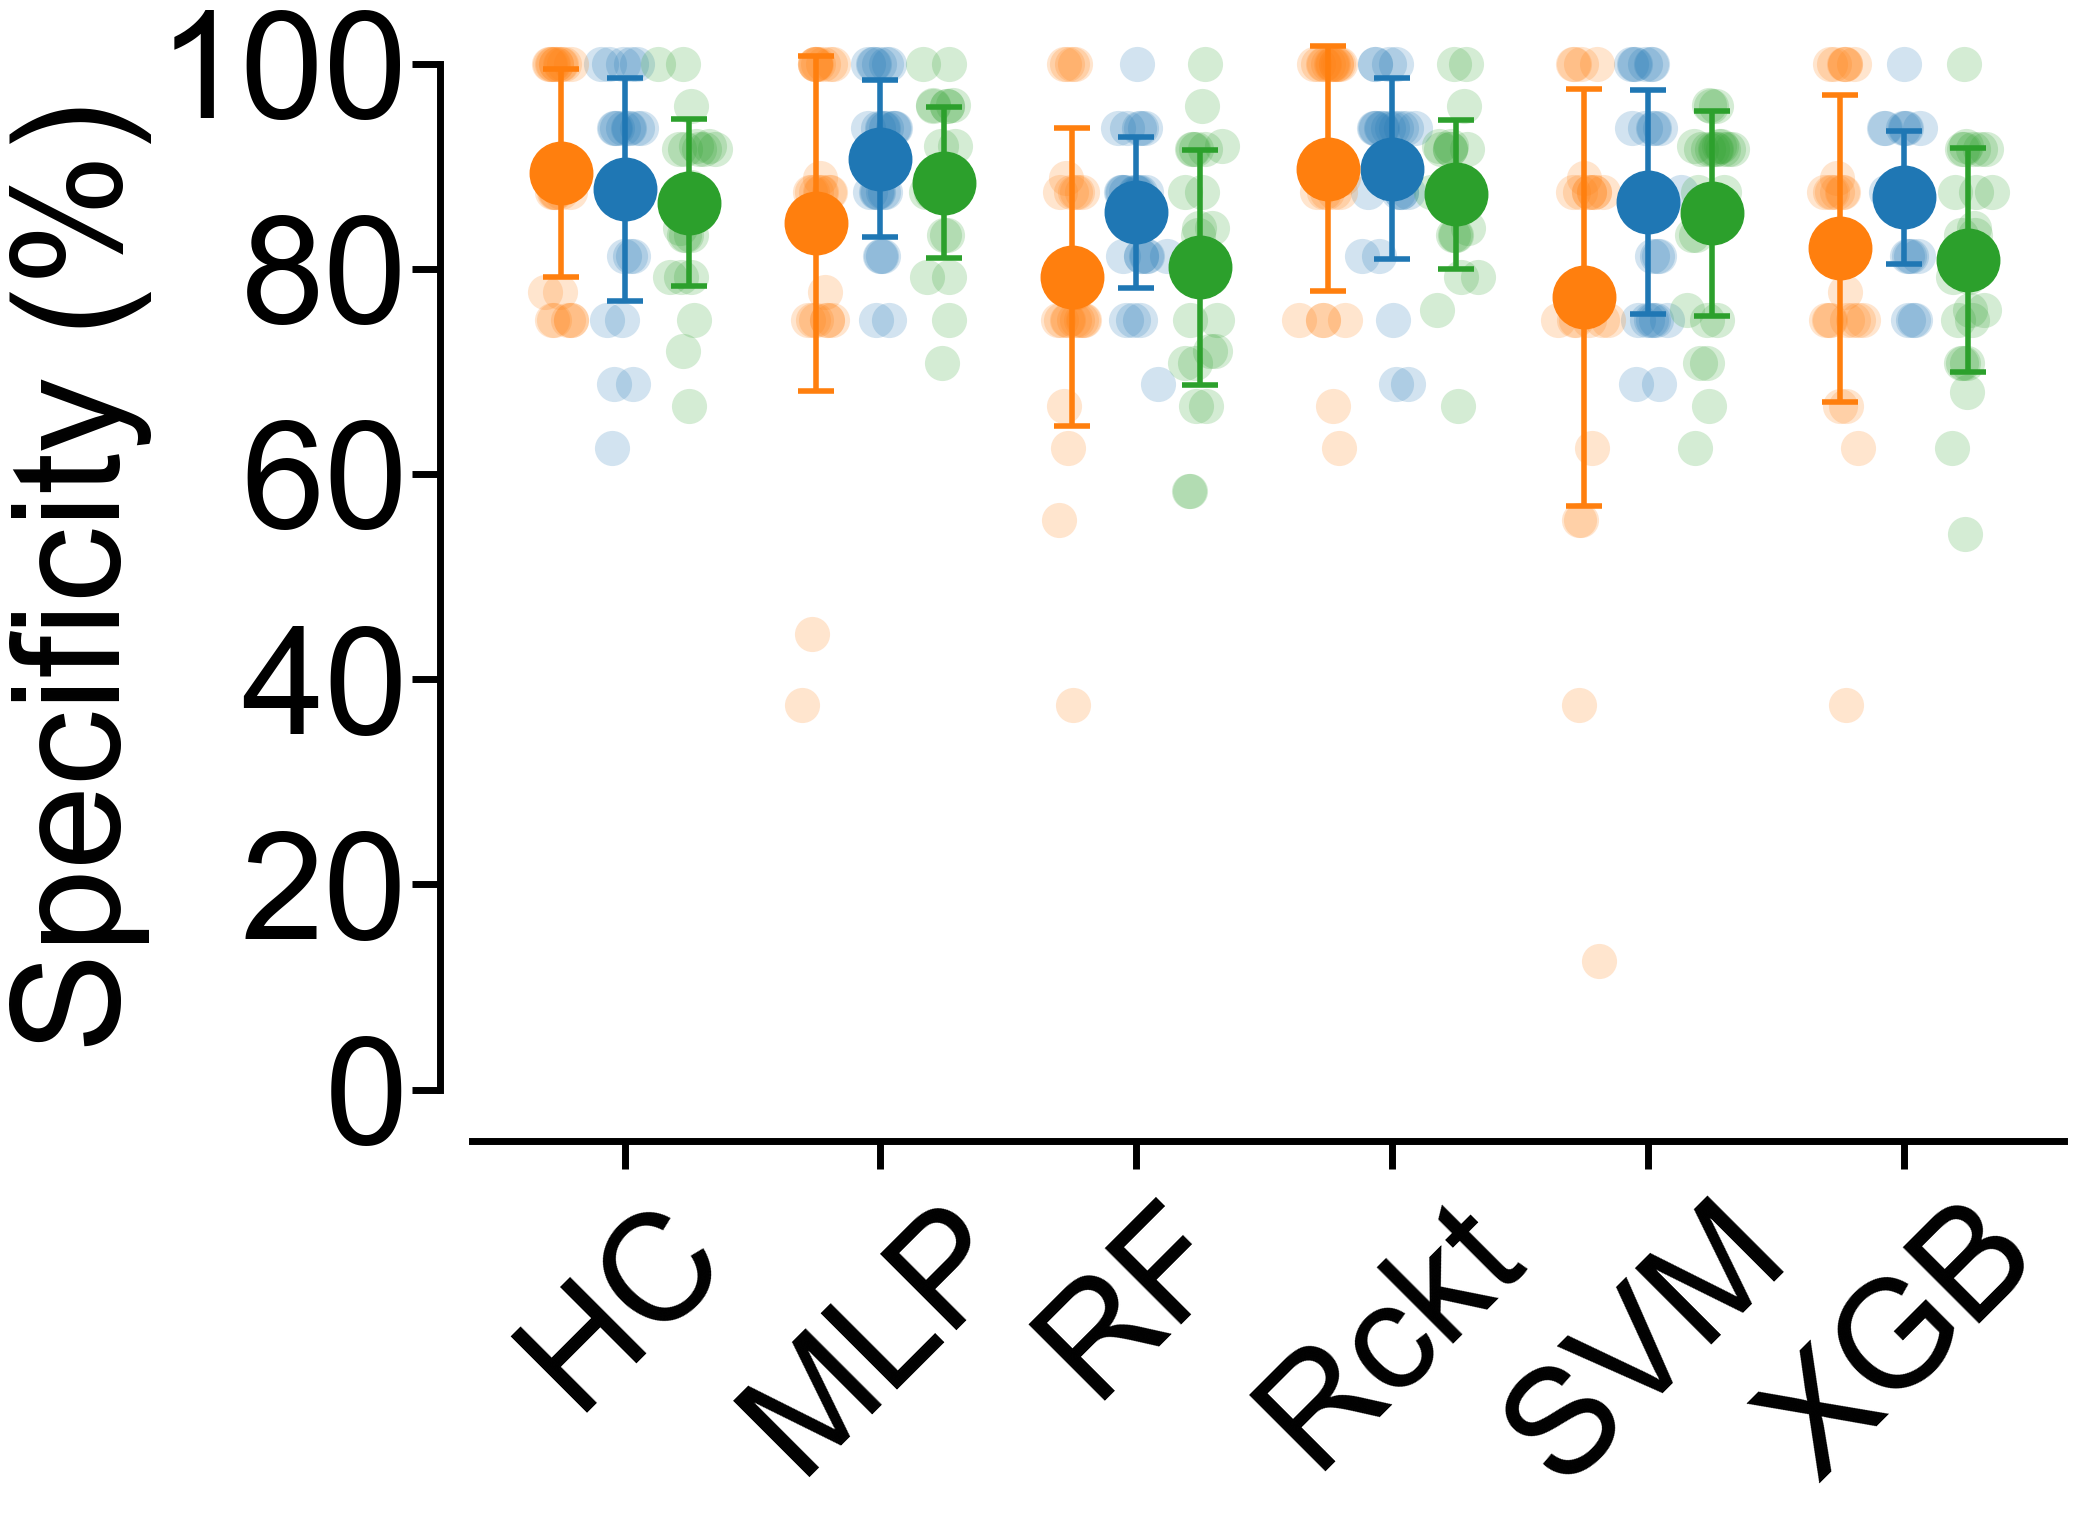

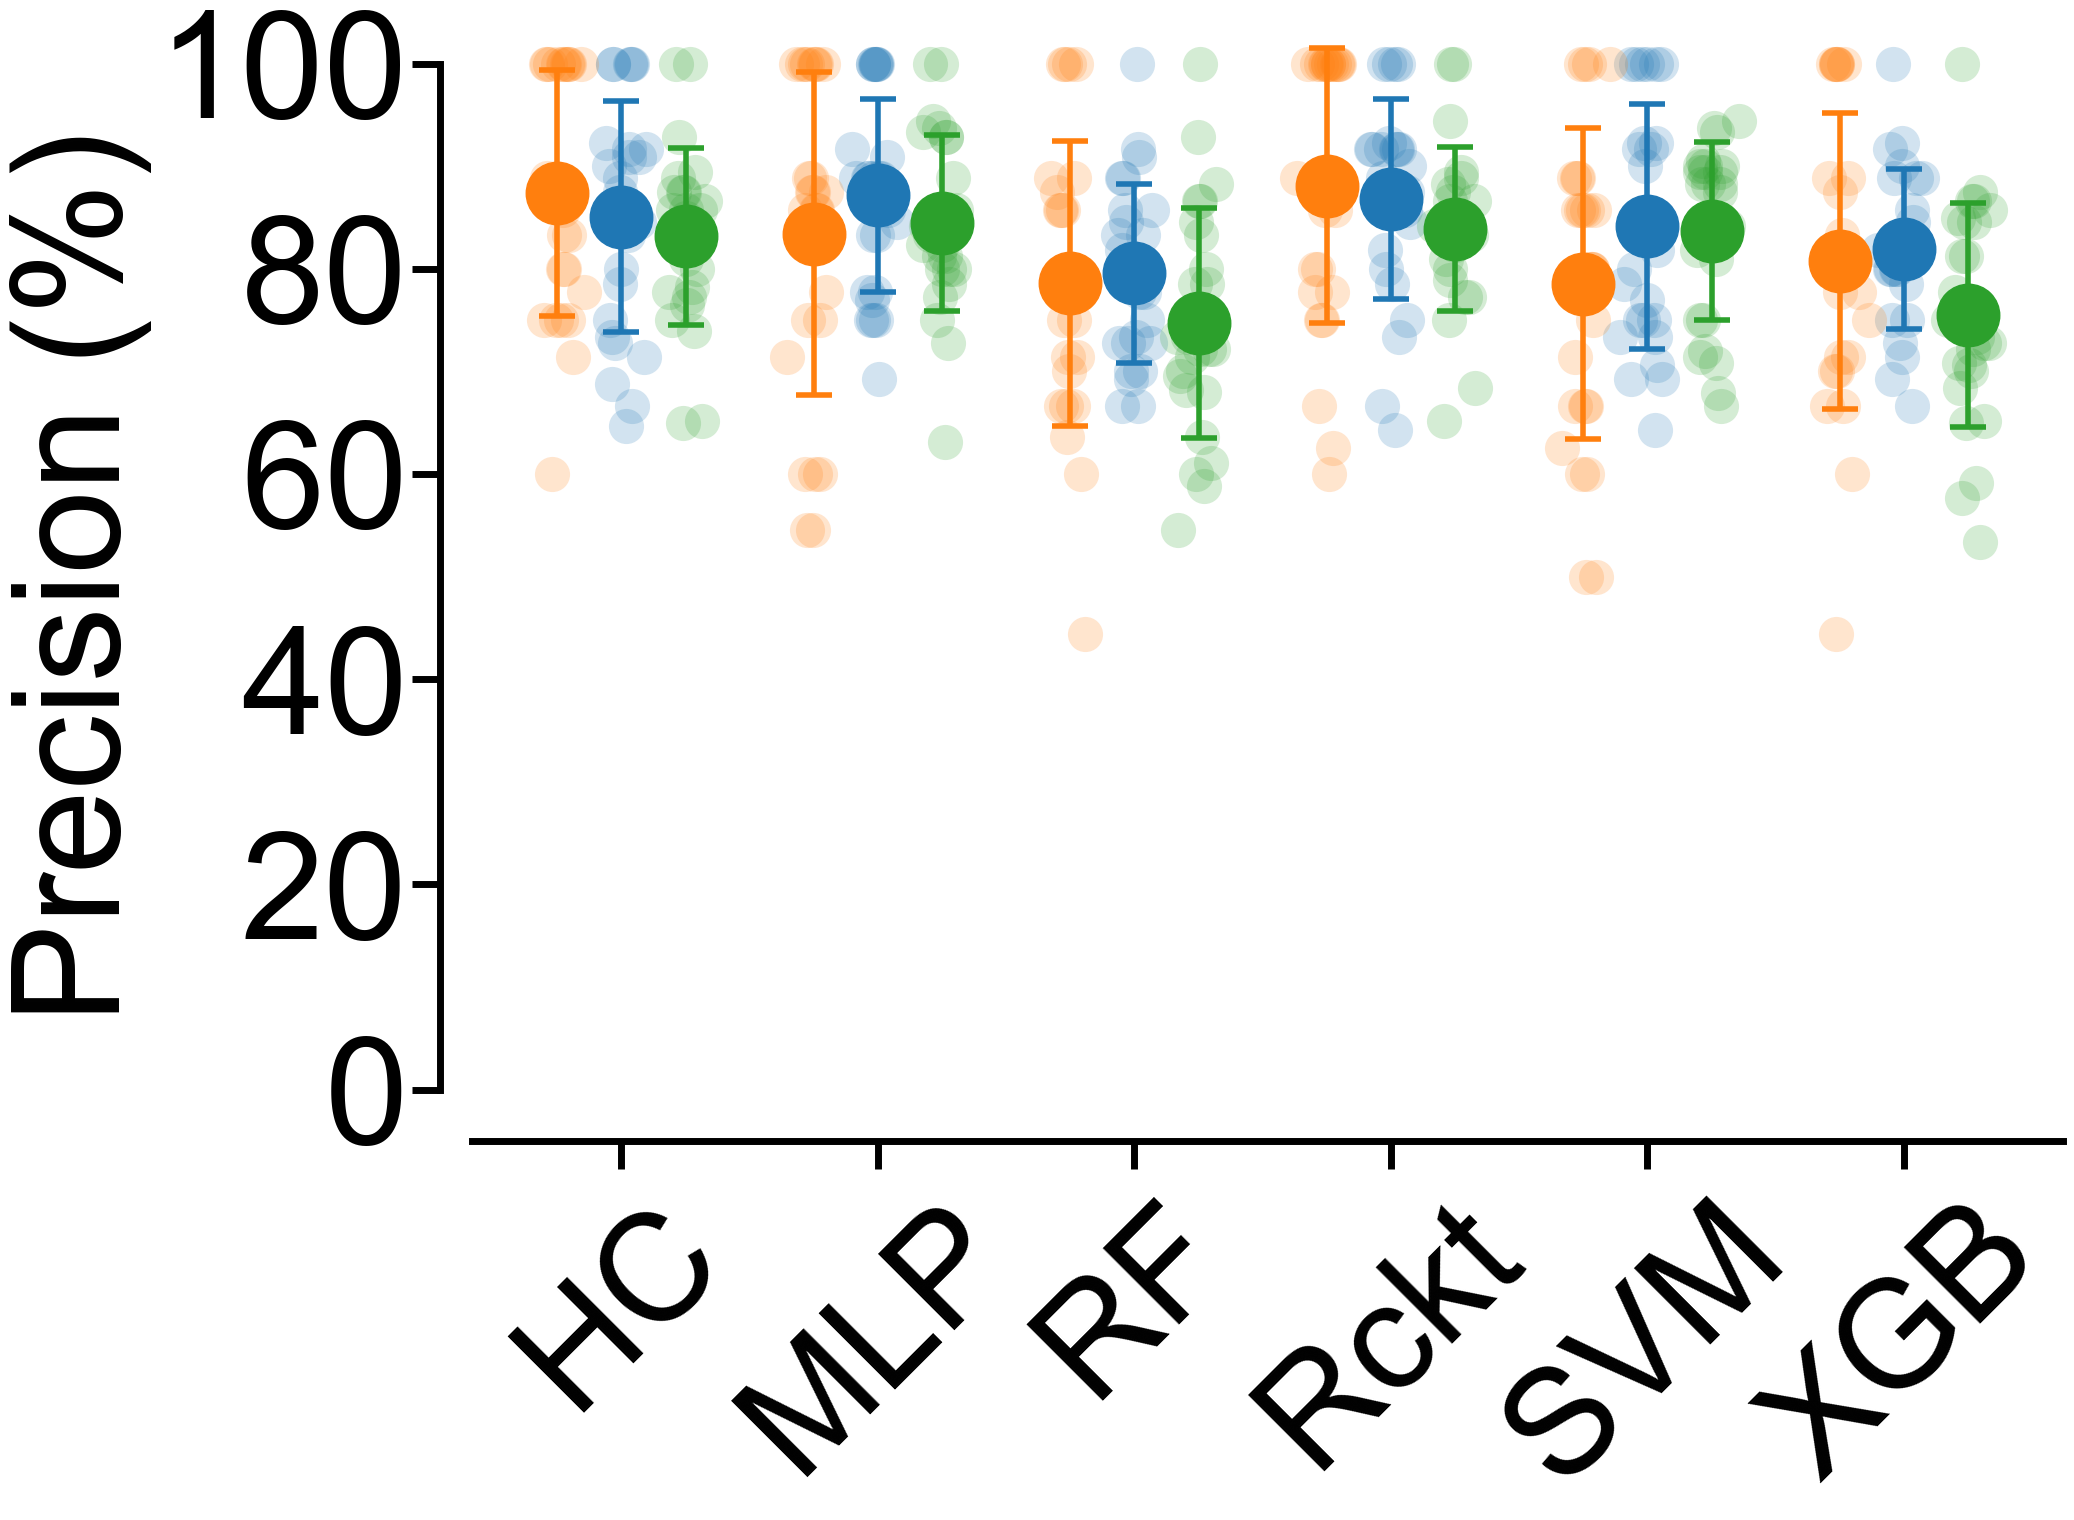

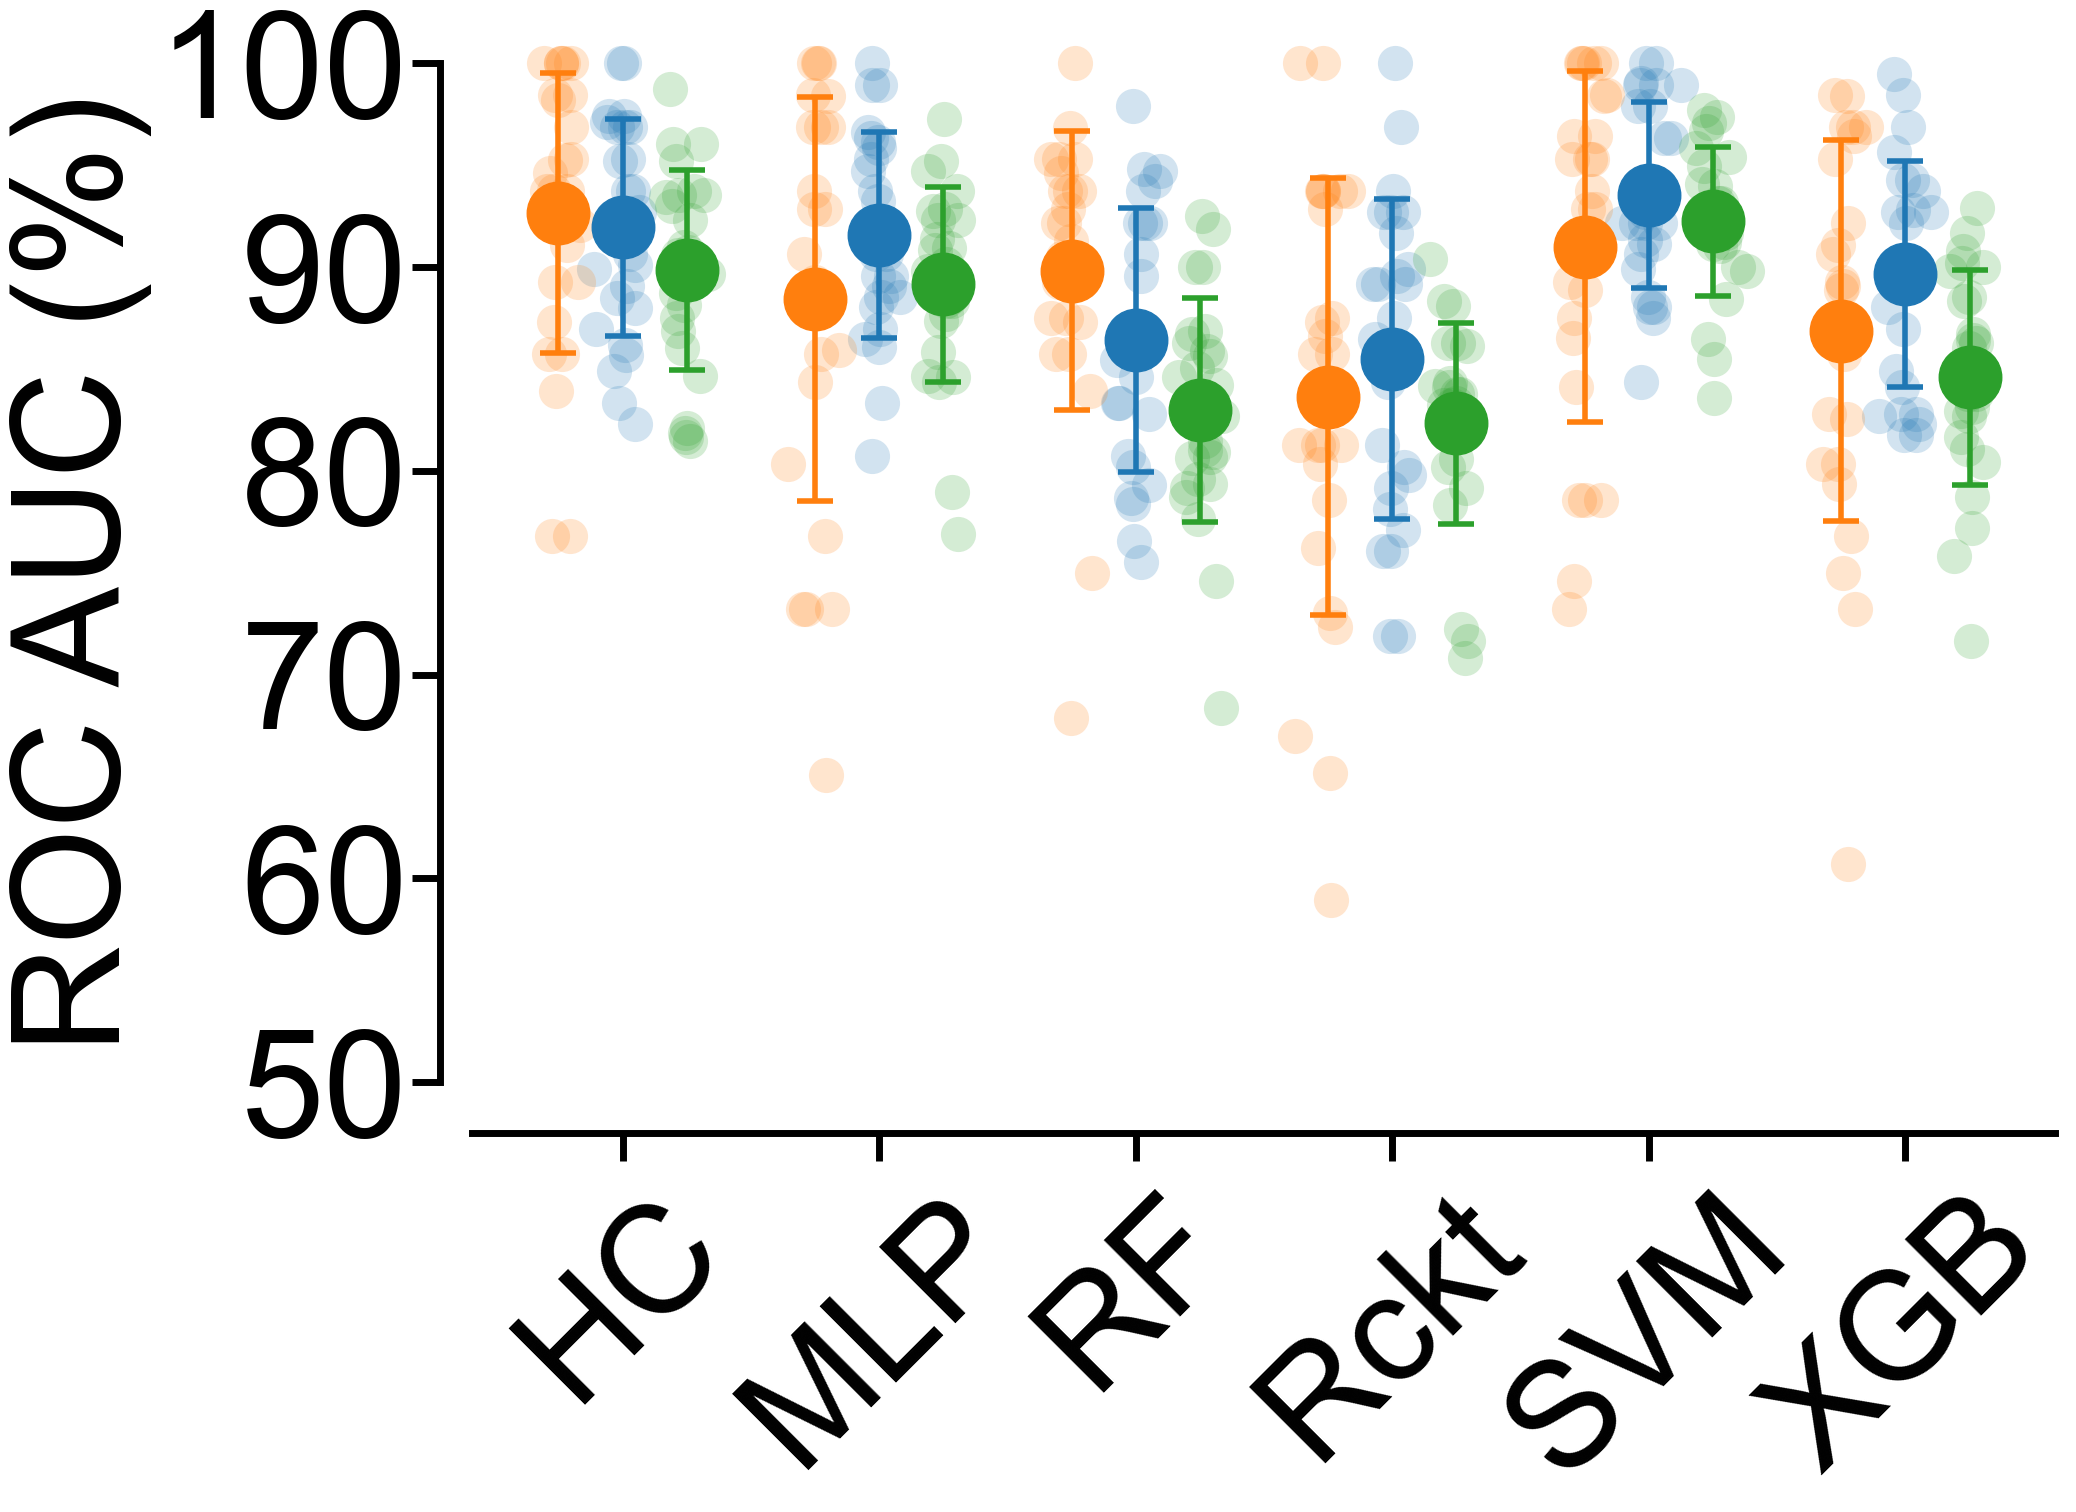

In [16]:

df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)
df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(50,100)
# ax.text(-0.5,60,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,56,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,52,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_accuracy_non_scaled.pdf',dpi=1200)


df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_6N',ylabel='Recall (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_6N',ylabel='Recall (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_6N',ylabel='Recall (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(0,100)
# ax.text(-0.5,18,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,10,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,2,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_recall_non_scaled.pdf',dpi=1200)


df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_Rep',ylabel='Specificity (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_Rep',ylabel='Specificity (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_Rep',ylabel='Specificity (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(0,100)
# ax.text(-0.5,18,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,10,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,2,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_specificity_non_scaled.pdf',dpi=1200)




df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_precision_scorer_6N',ylabel='Precision (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_precision_scorer_6N',ylabel='Precision (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_precision_scorer_6N',ylabel='Precision (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(0,100)
# ax.text(-0.5,18,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,10,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,2,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_precision_non_scaled.pdf',dpi=1200)











df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'roc_auc_score',ylabel='ROC AUC (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'roc_auc_score',ylabel='ROC AUC (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'roc_auc_score',ylabel='ROC AUC (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(50,100)
# ax.text(-0.5,60,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,56,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,52,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_rocauc_non_scaled.pdf',dpi=1200)




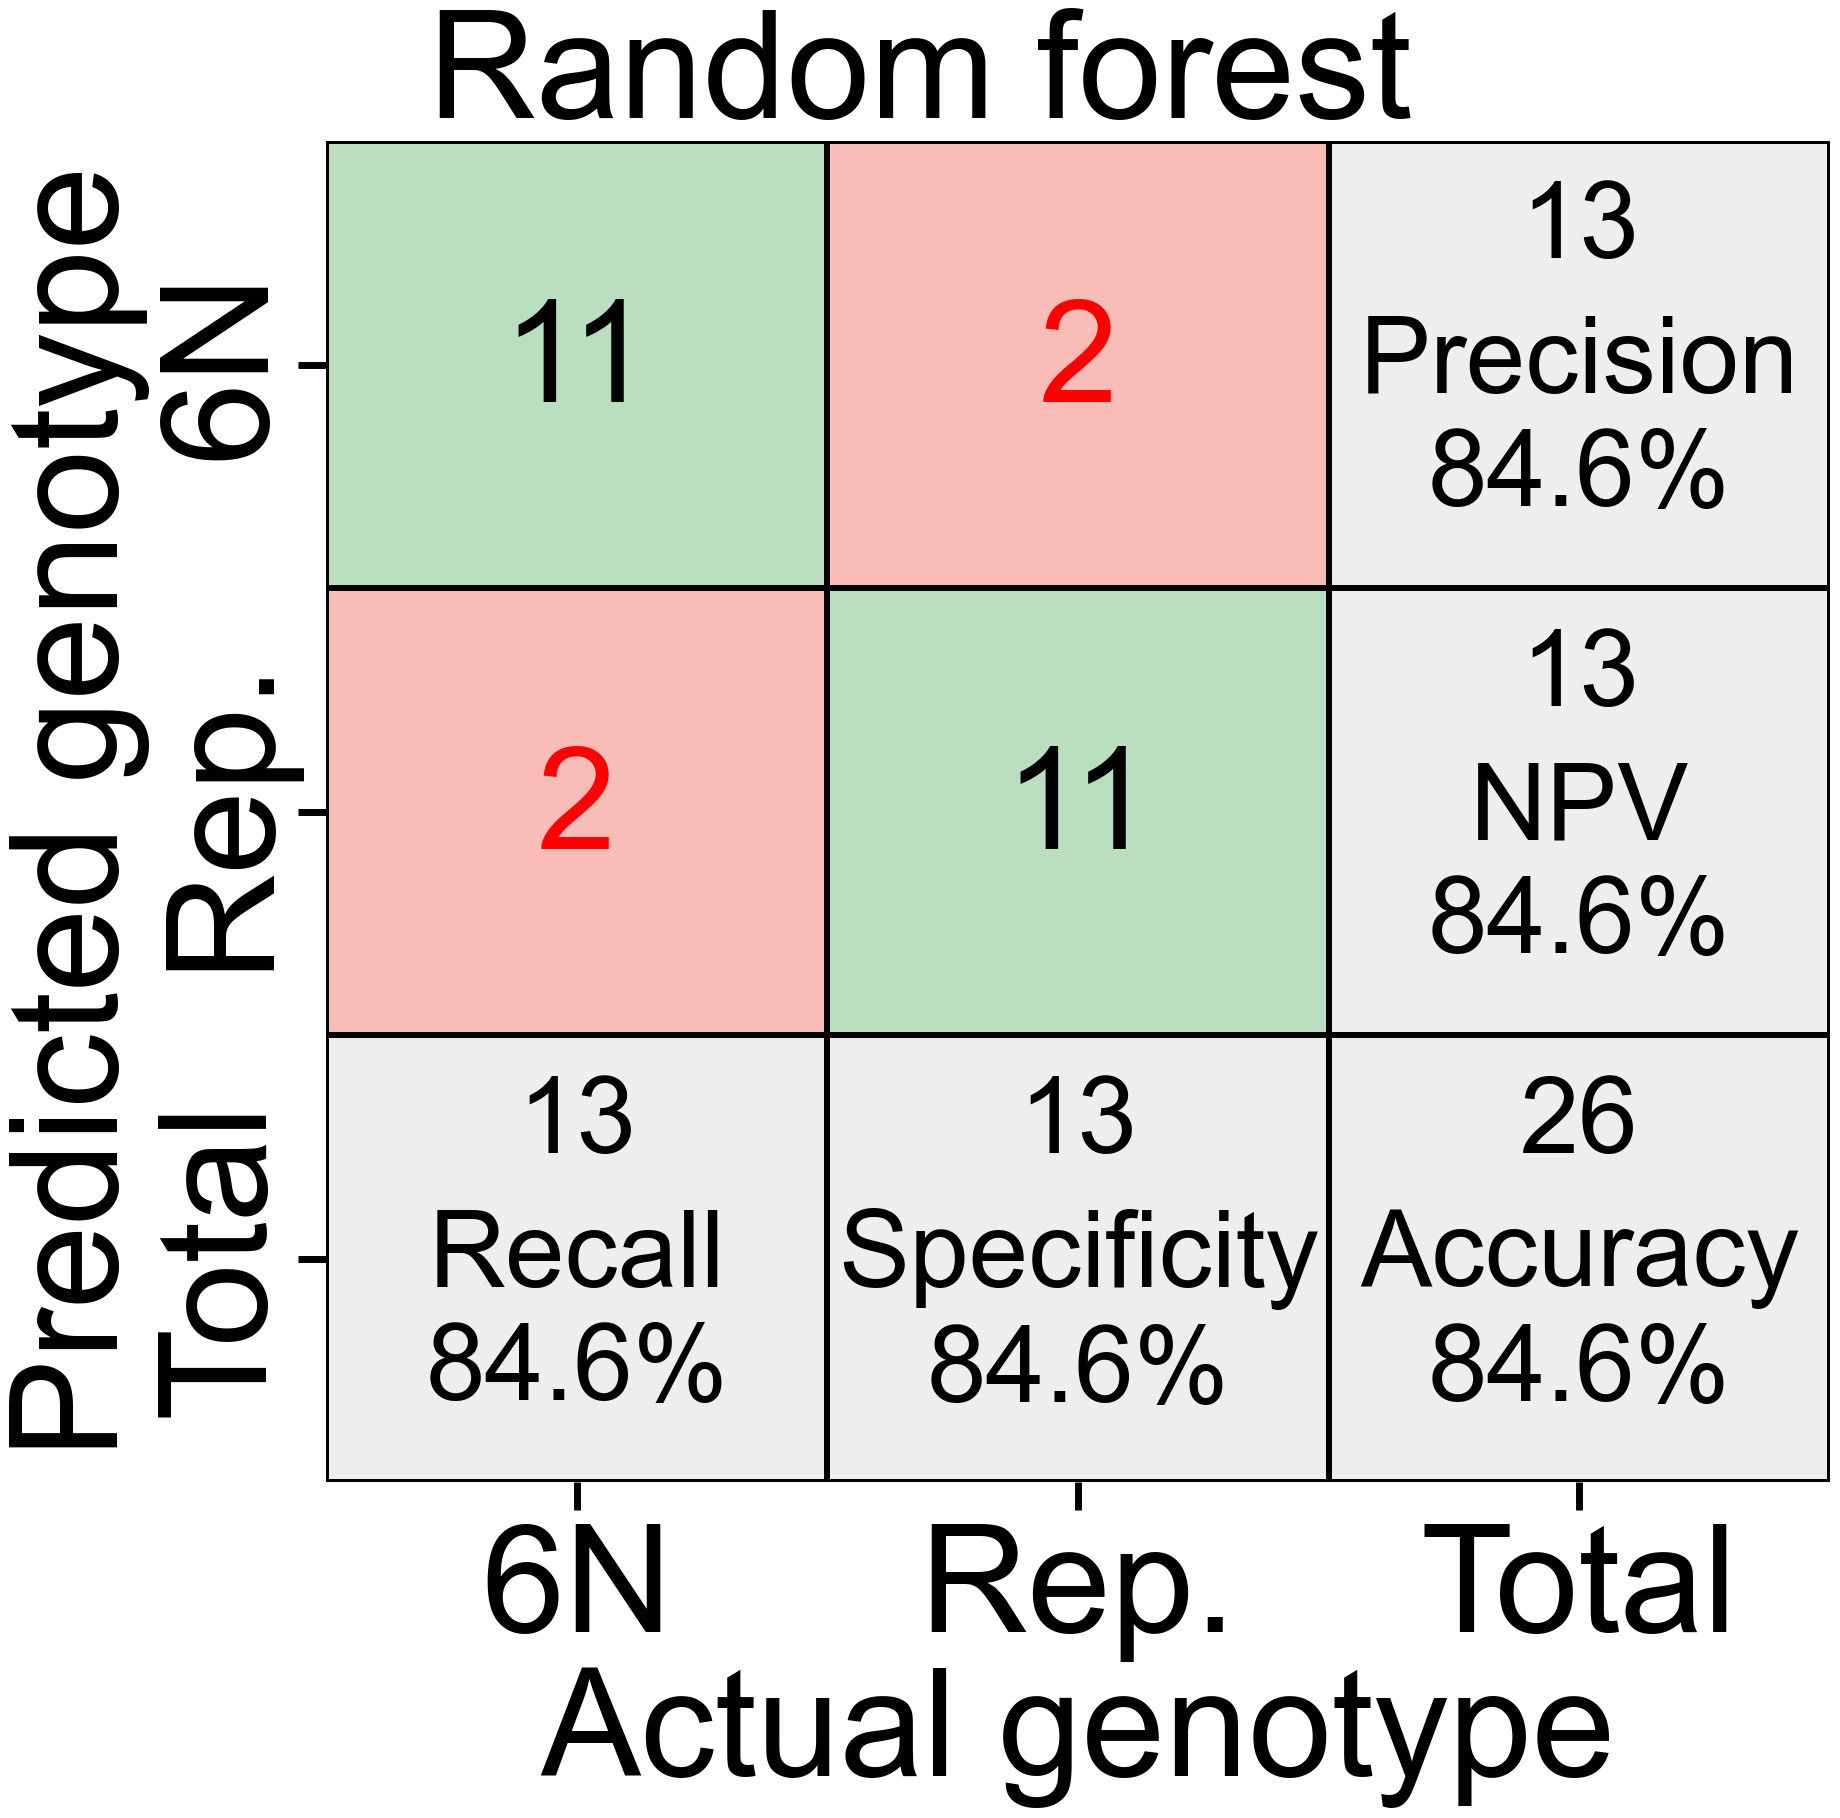

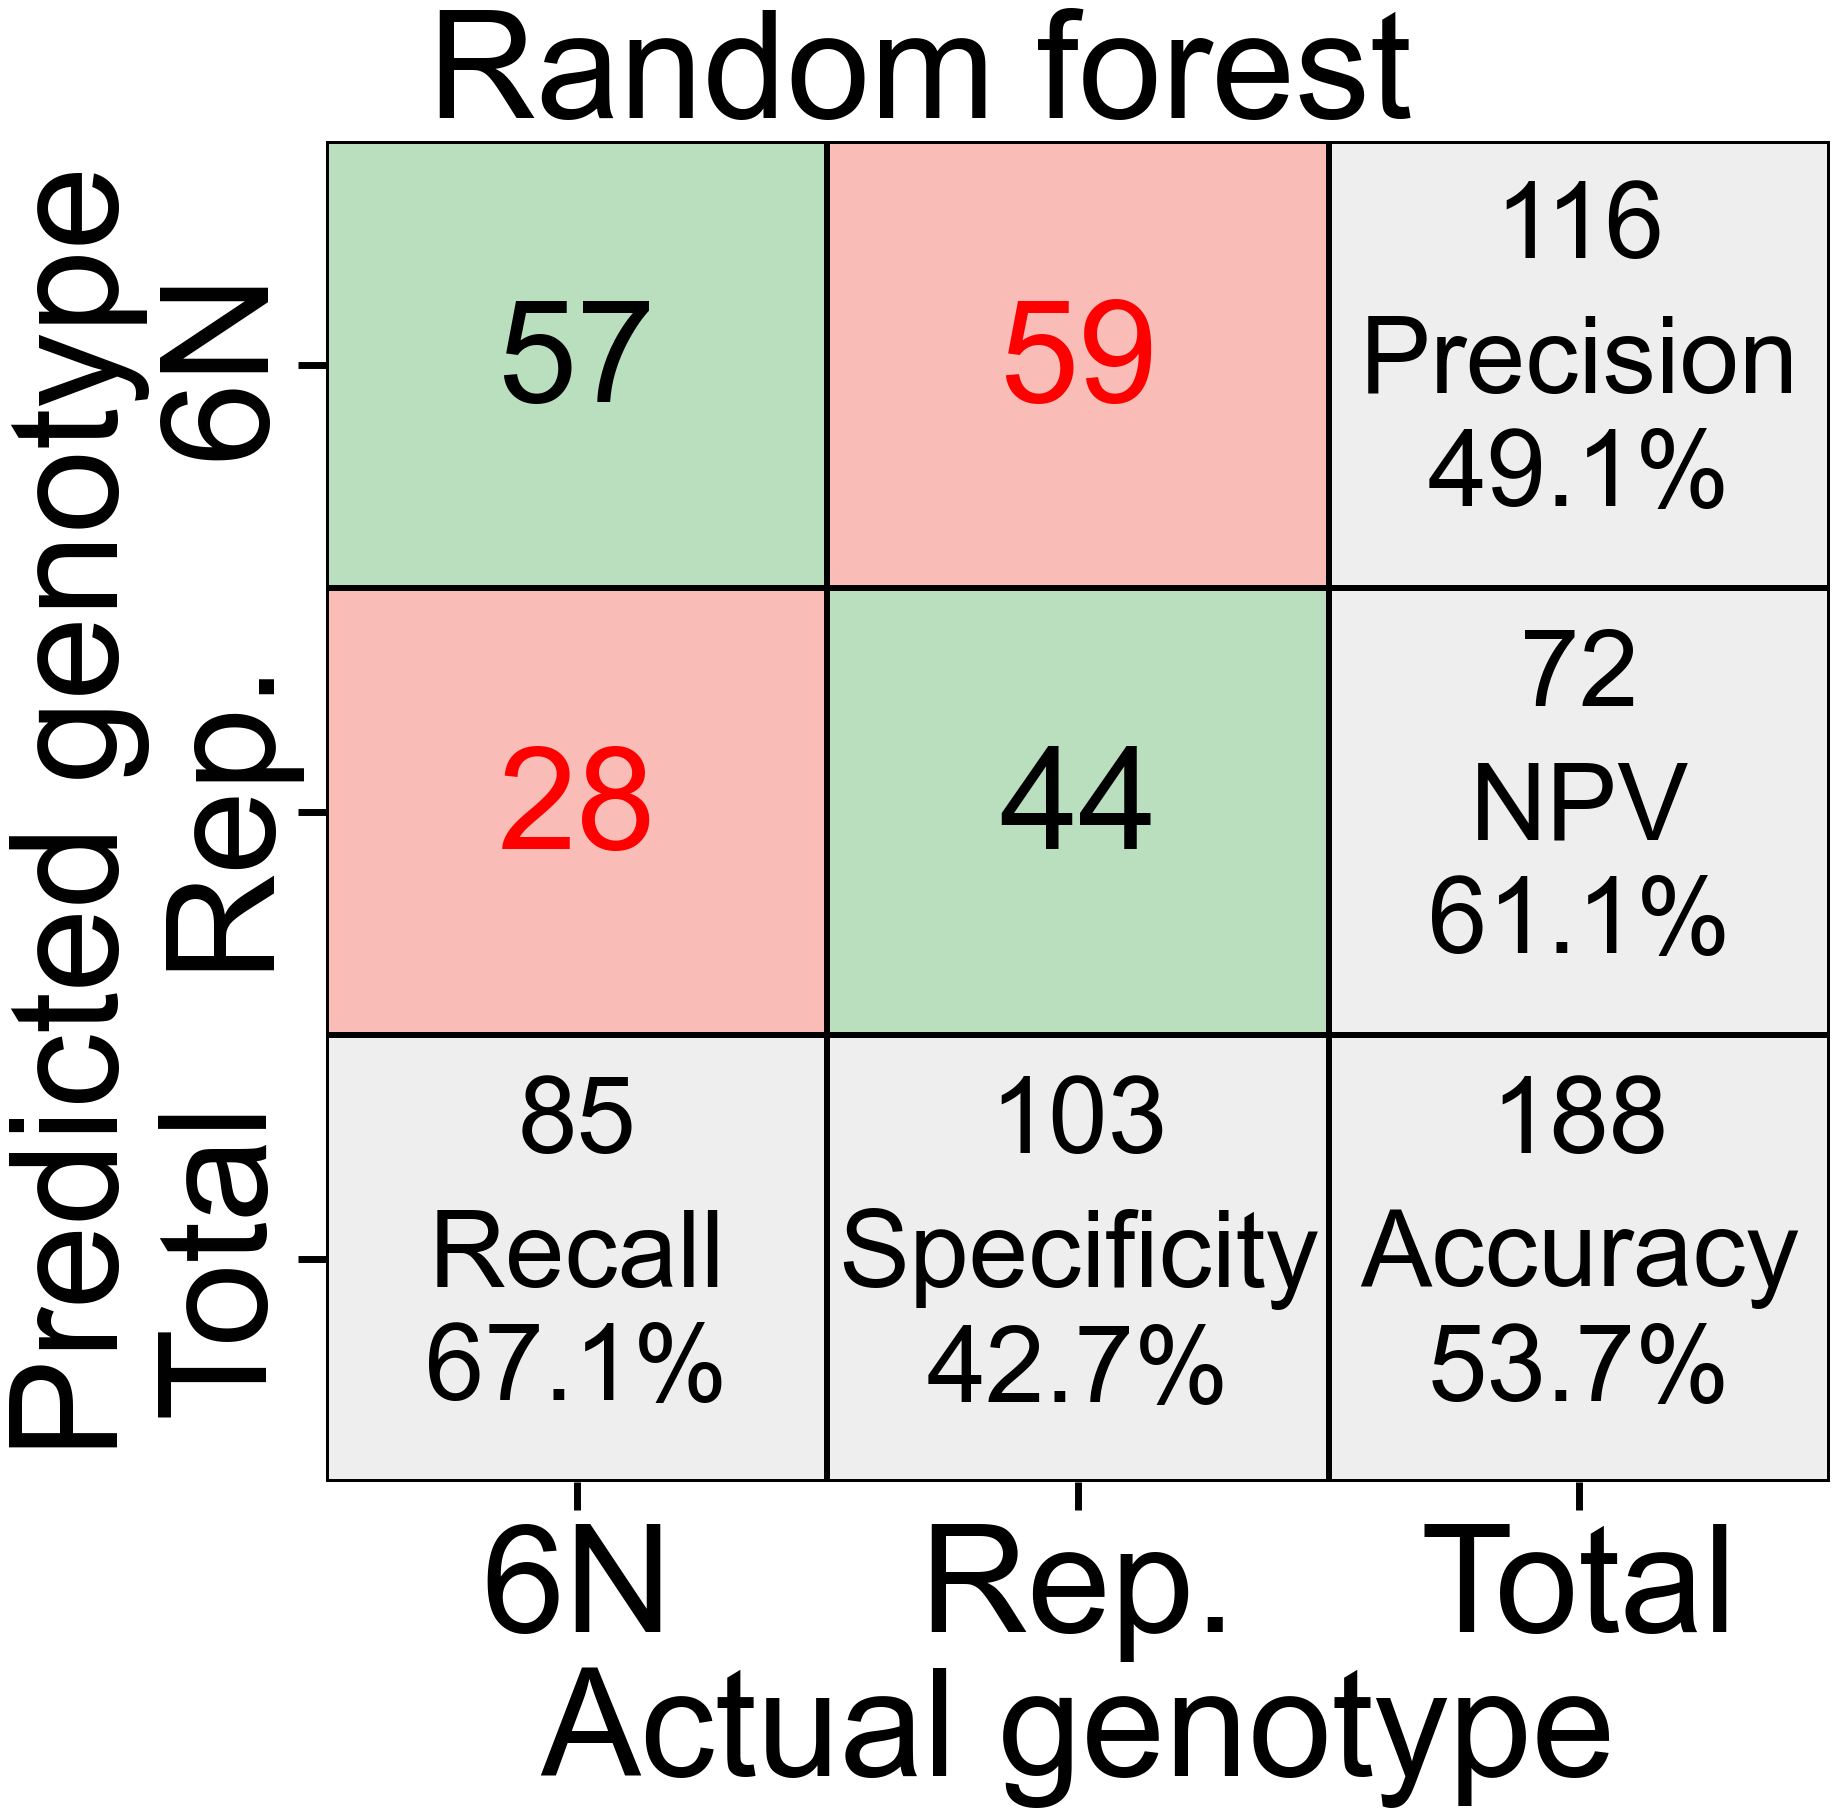

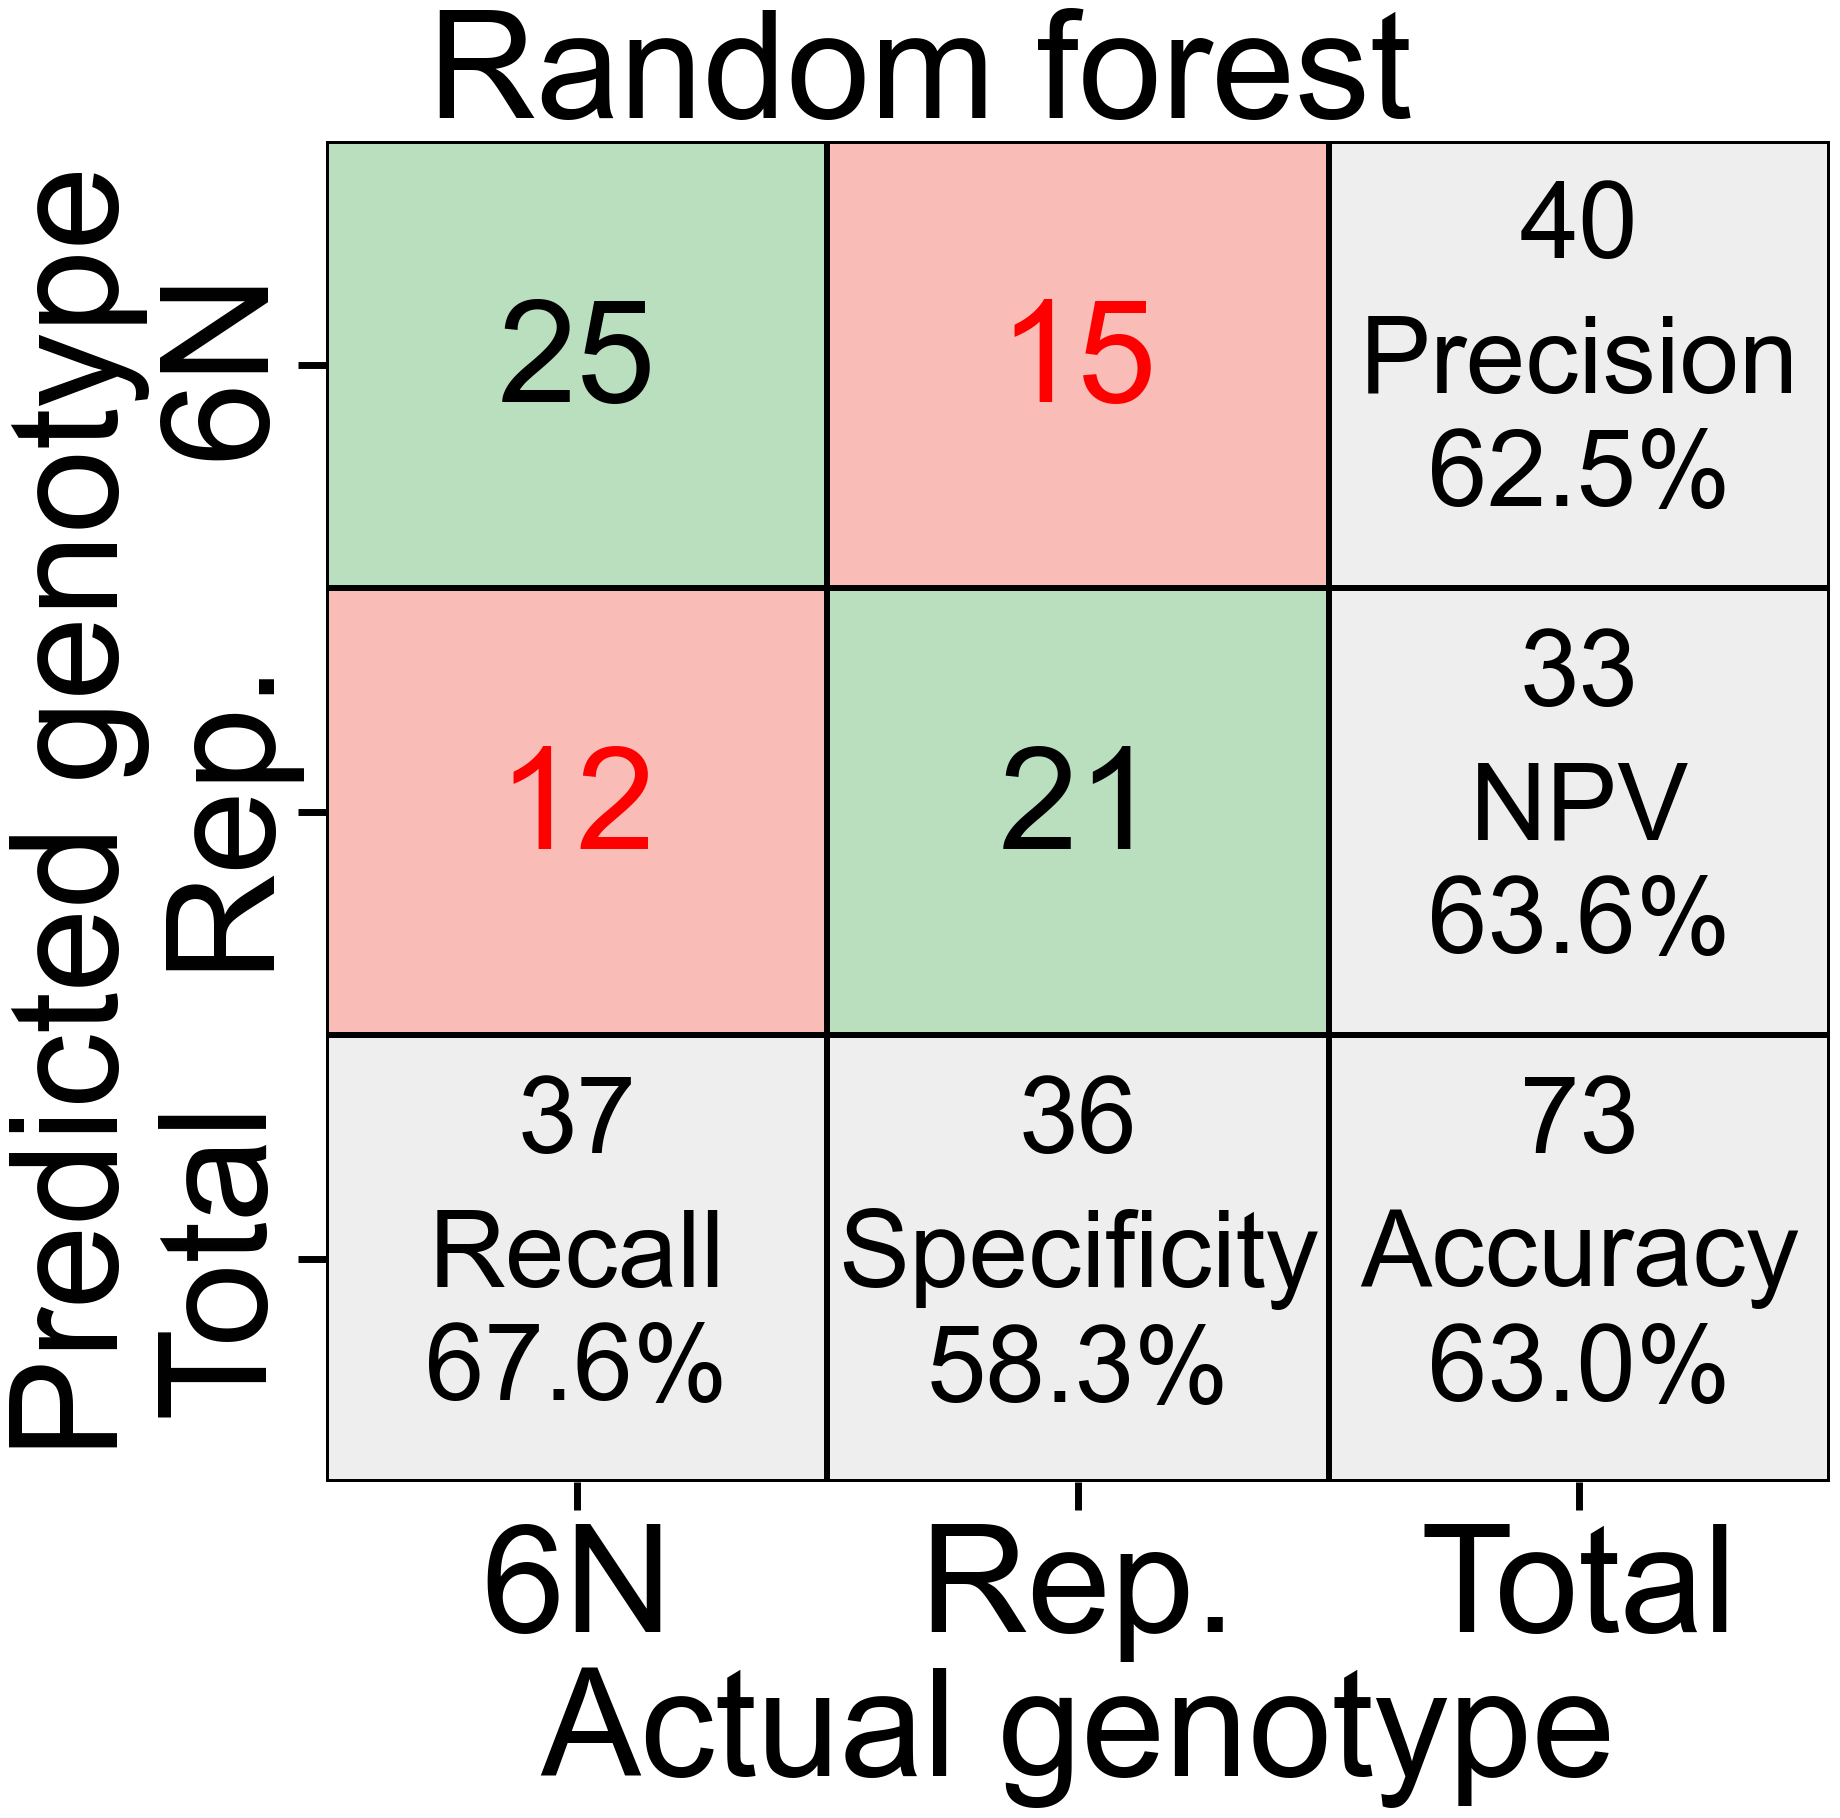

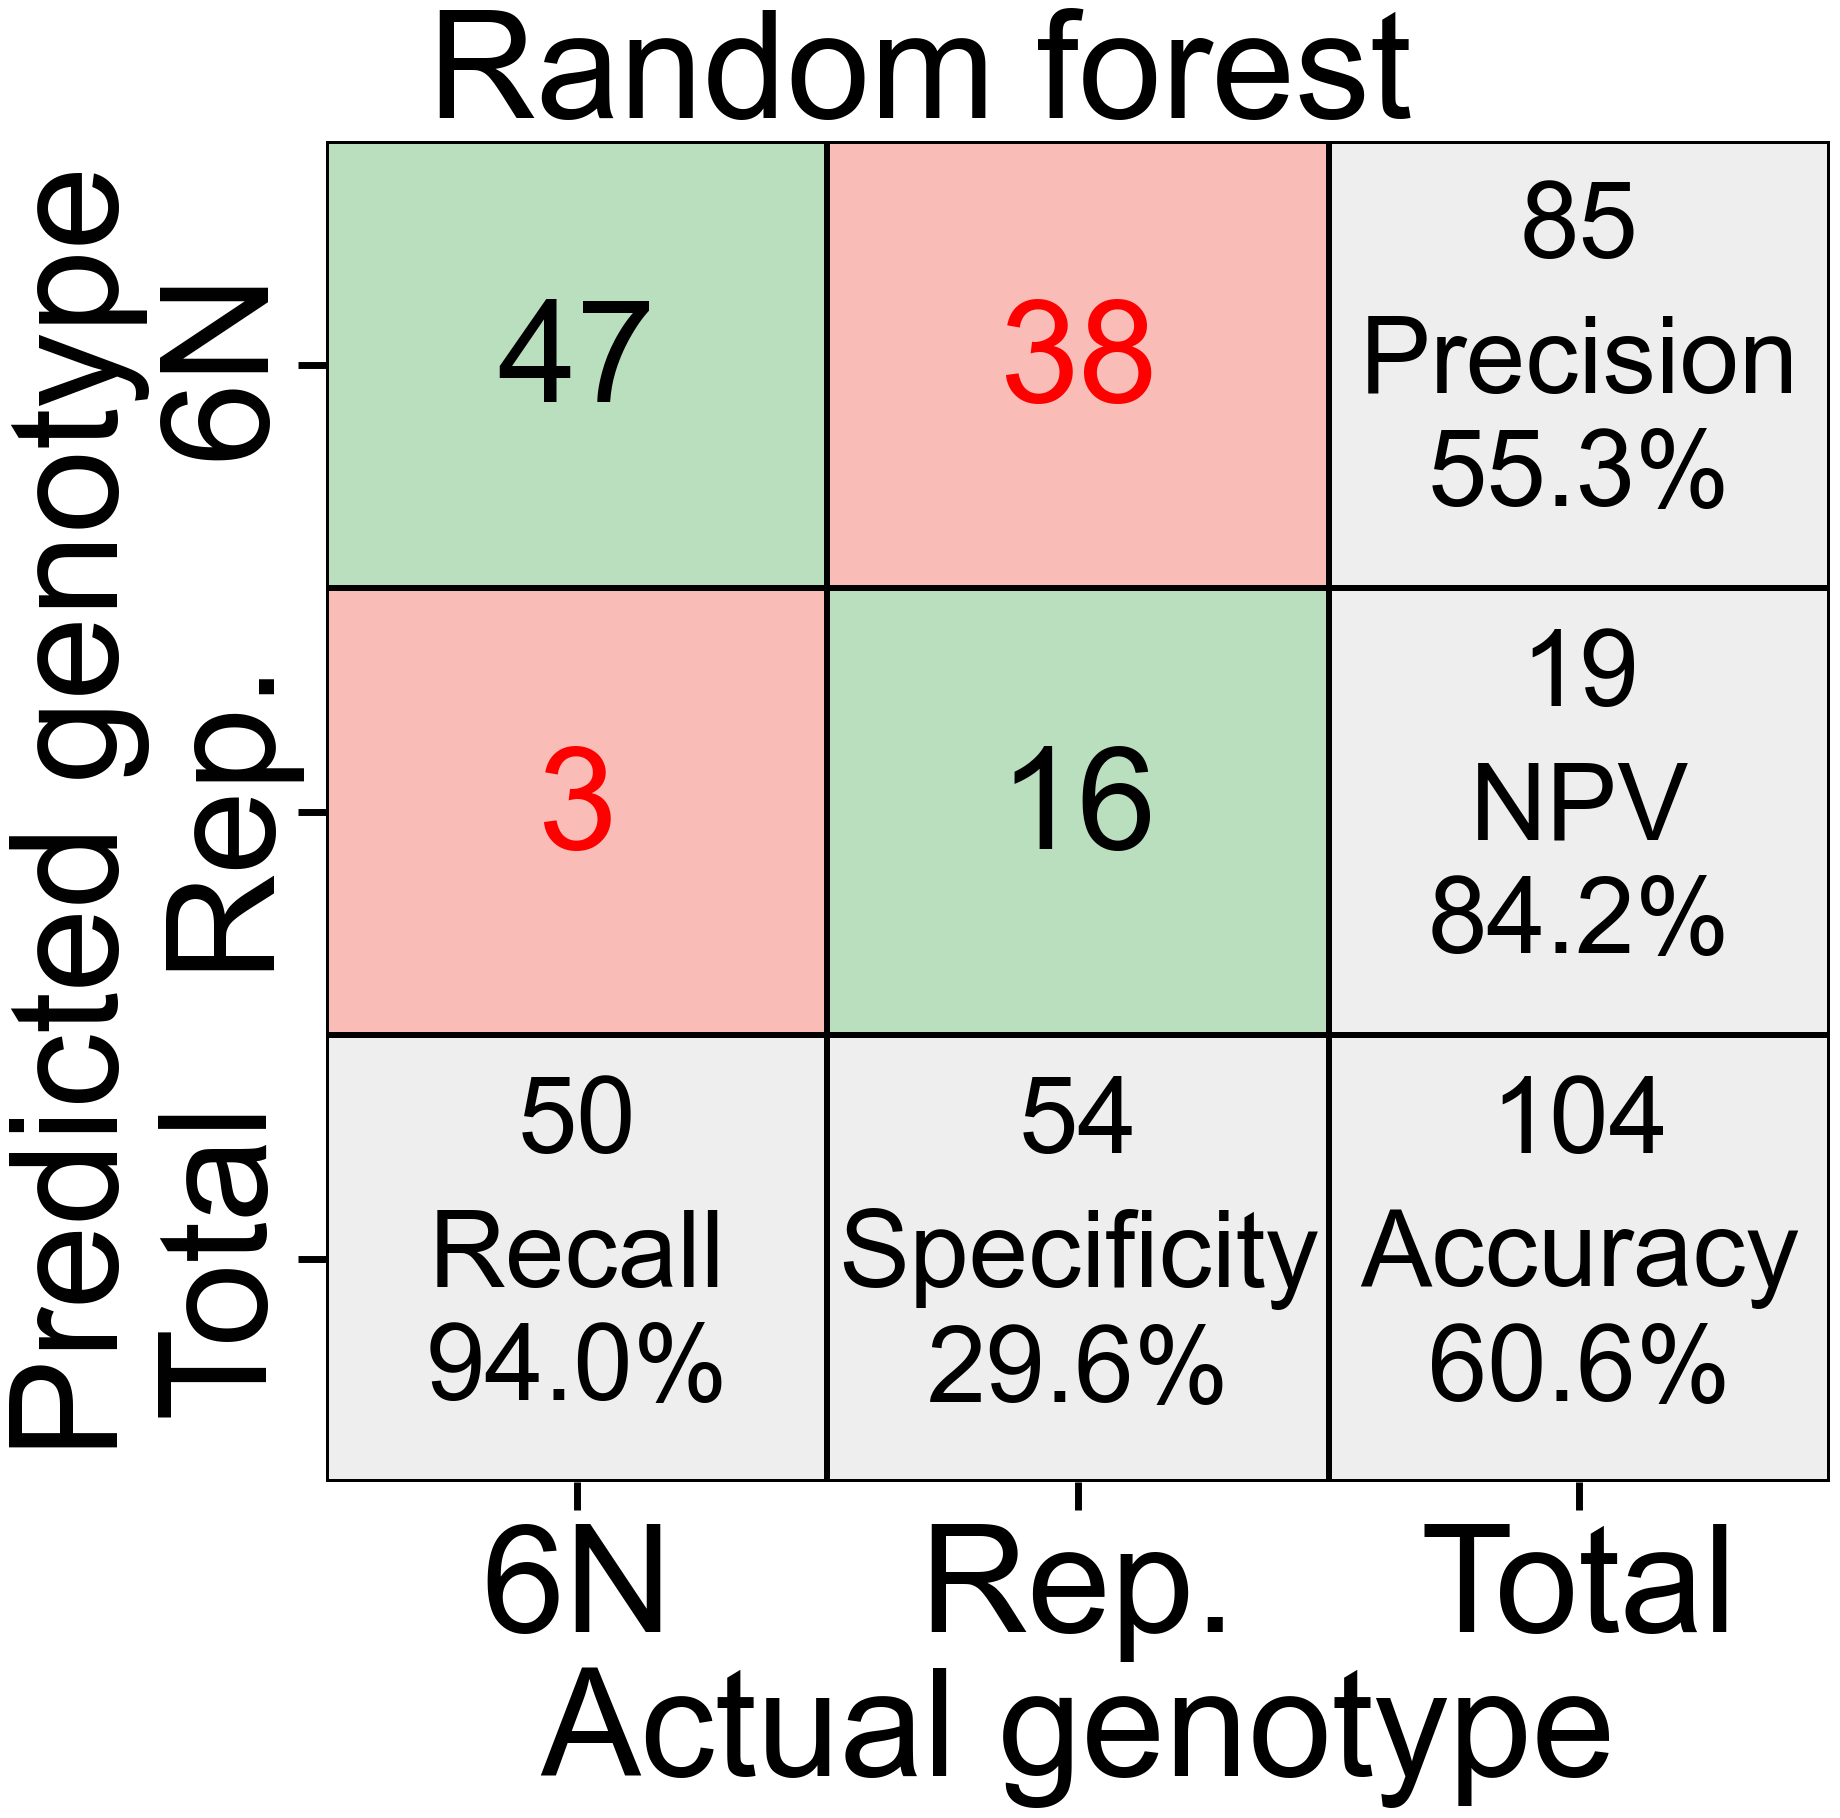

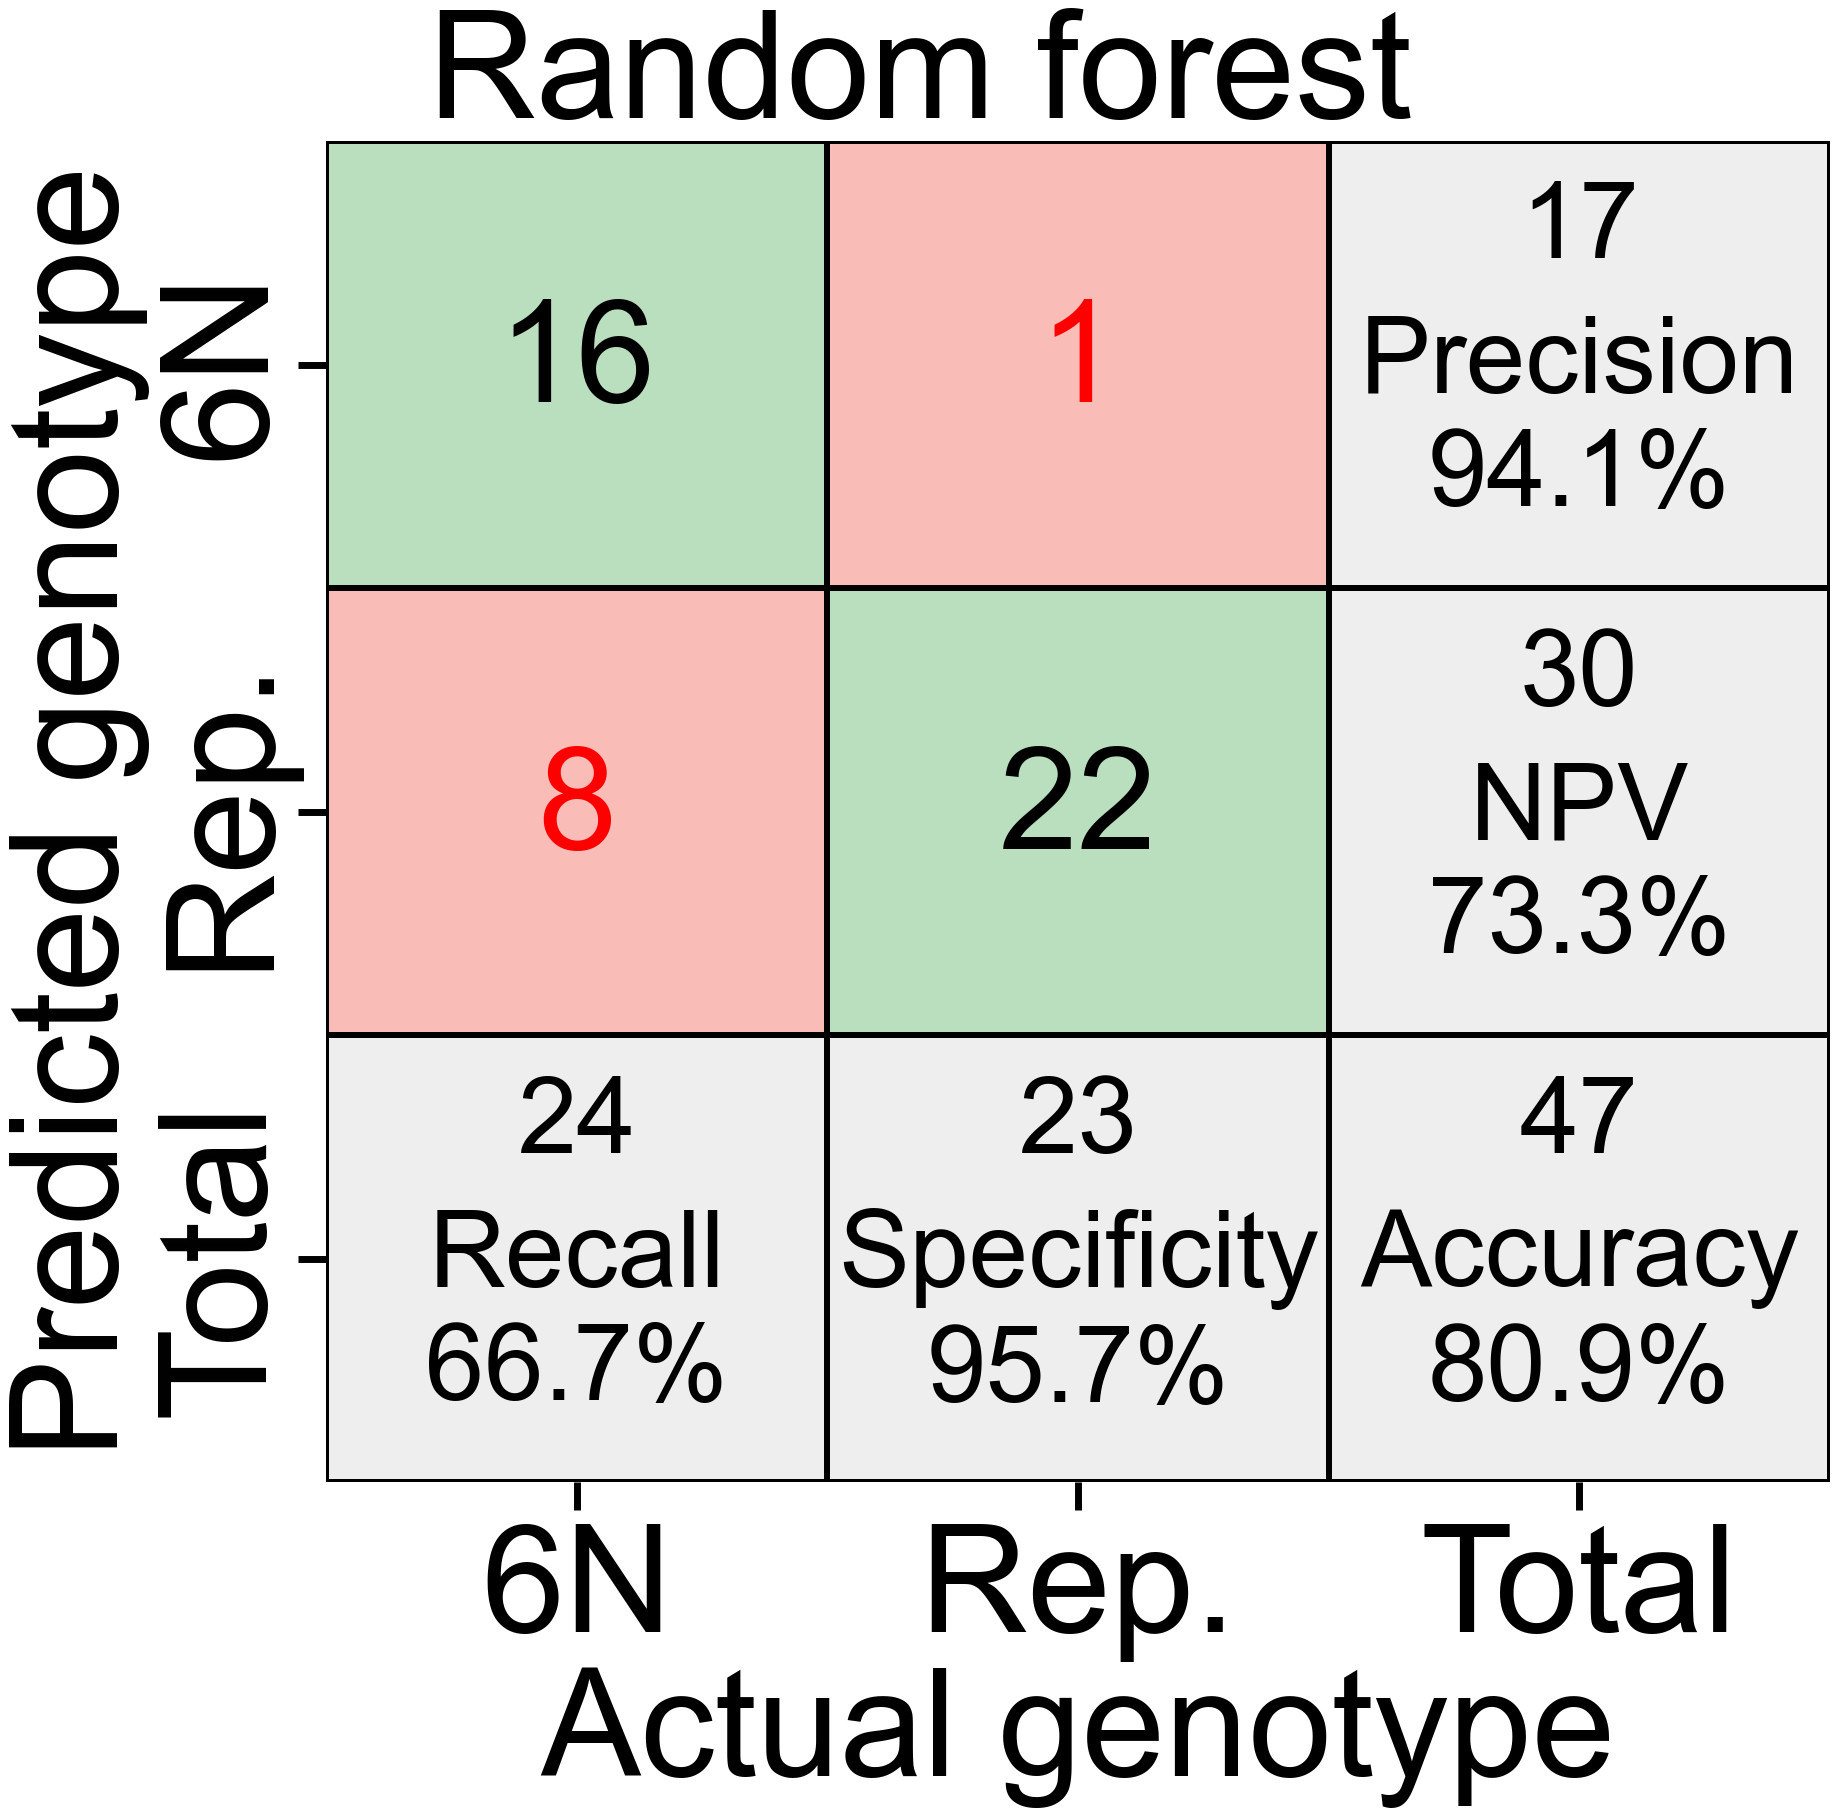

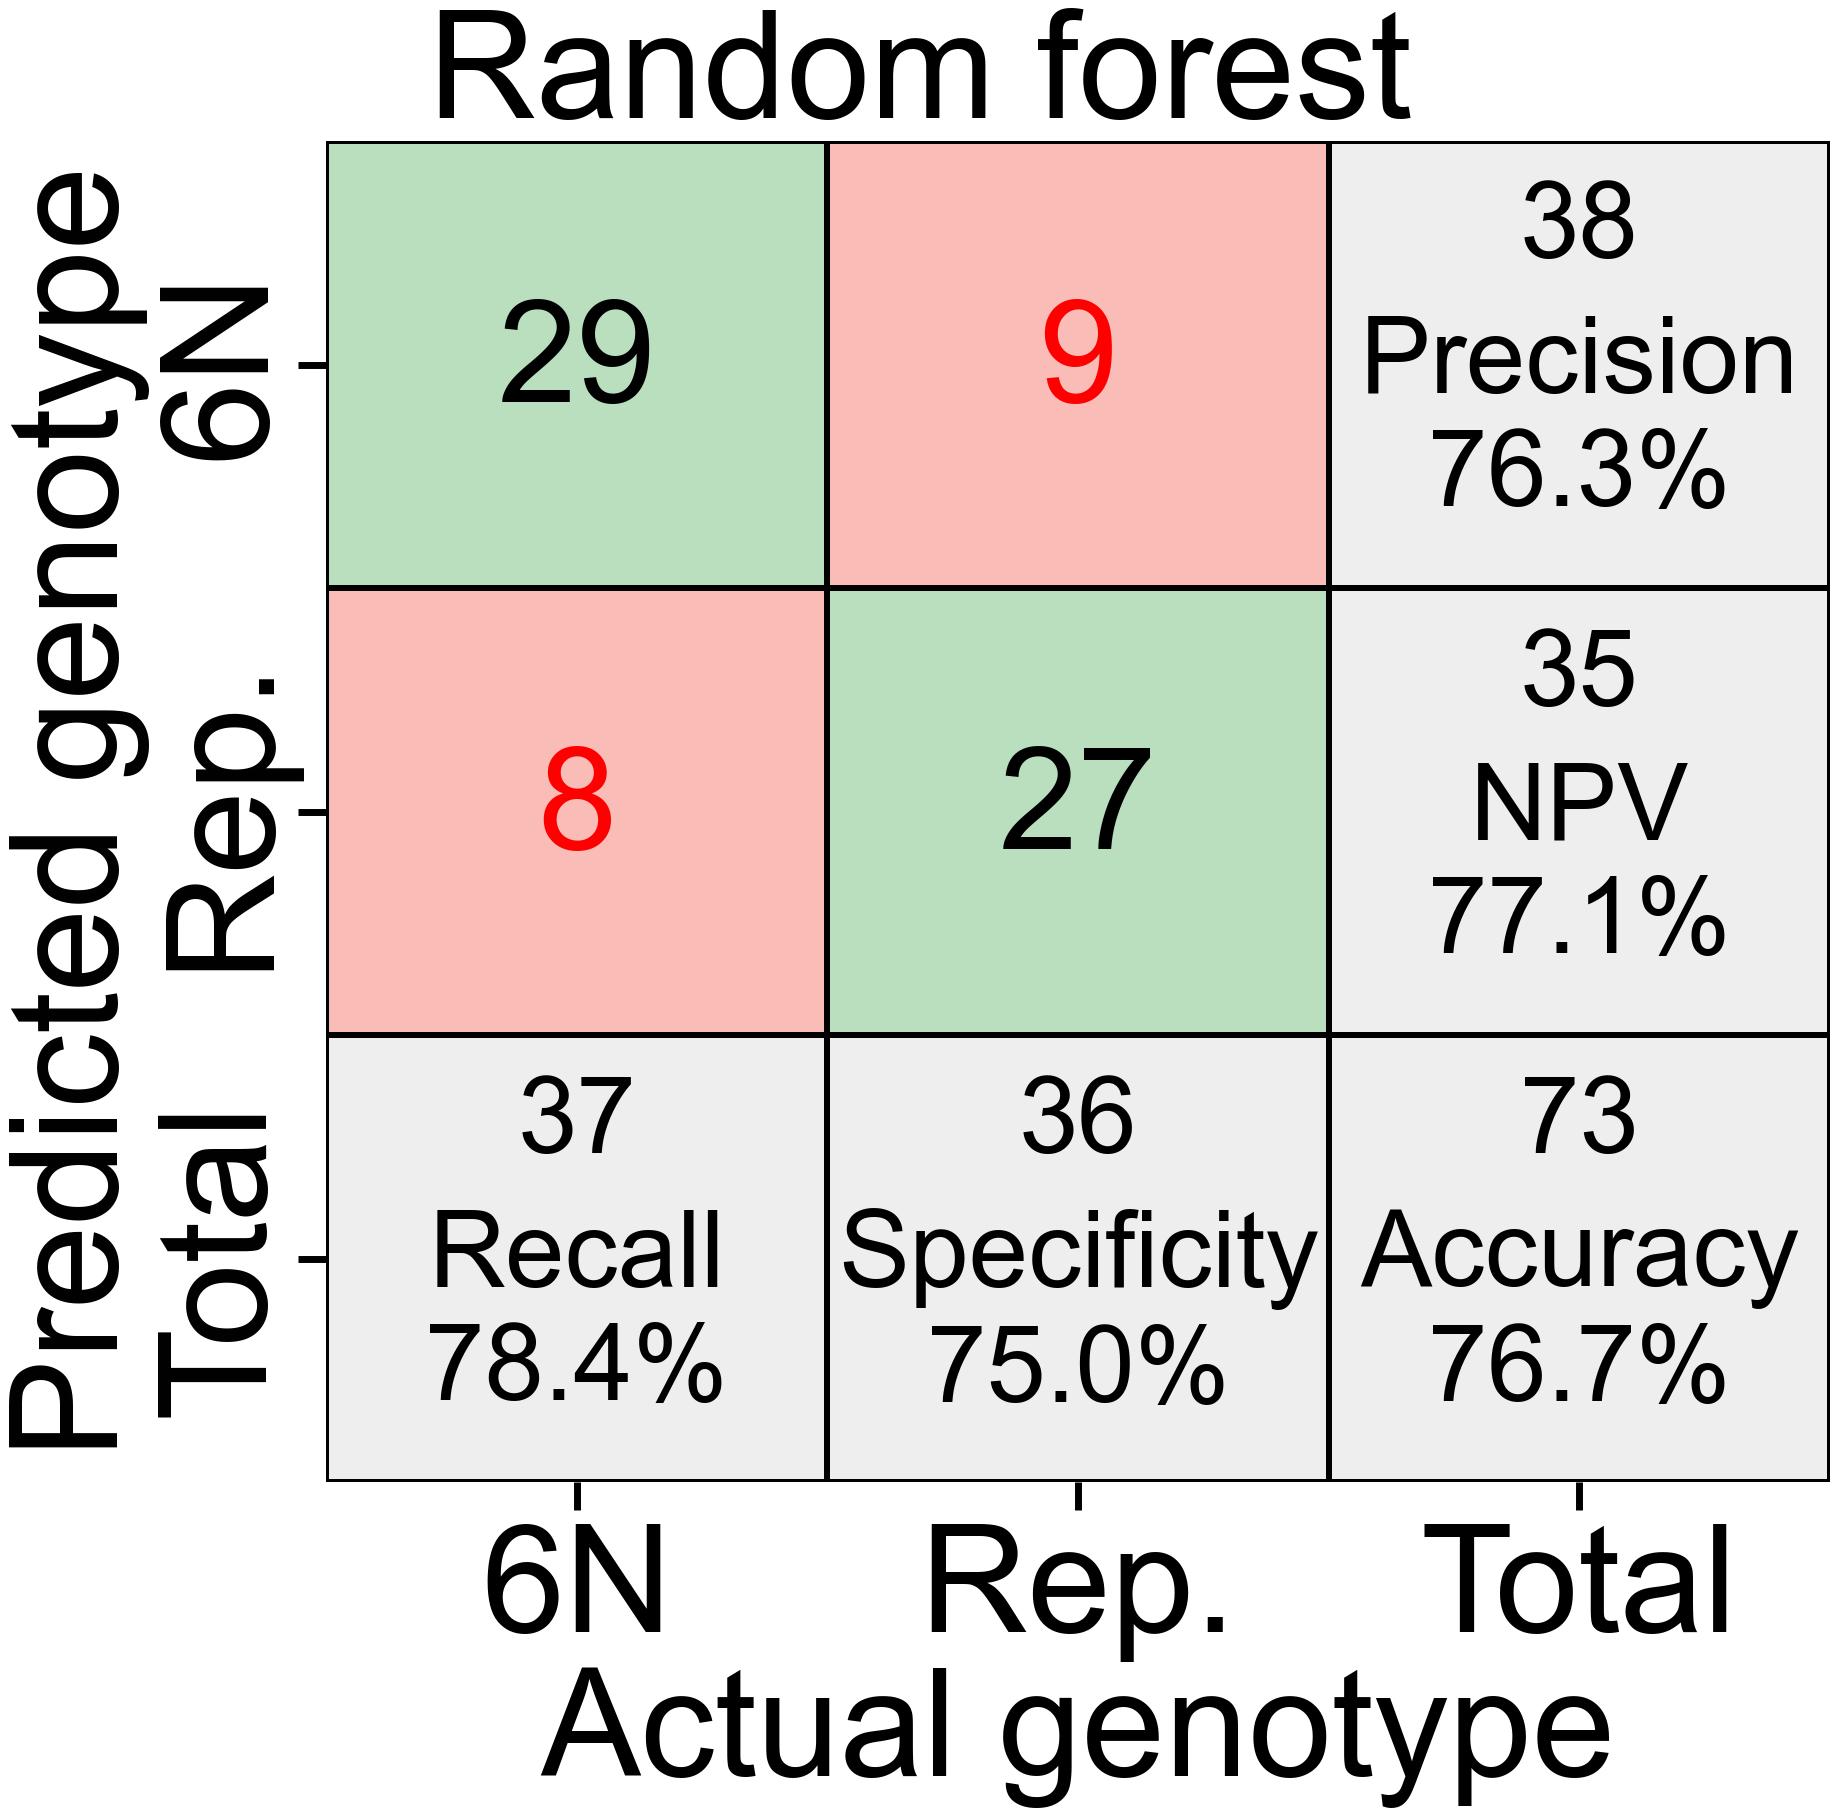

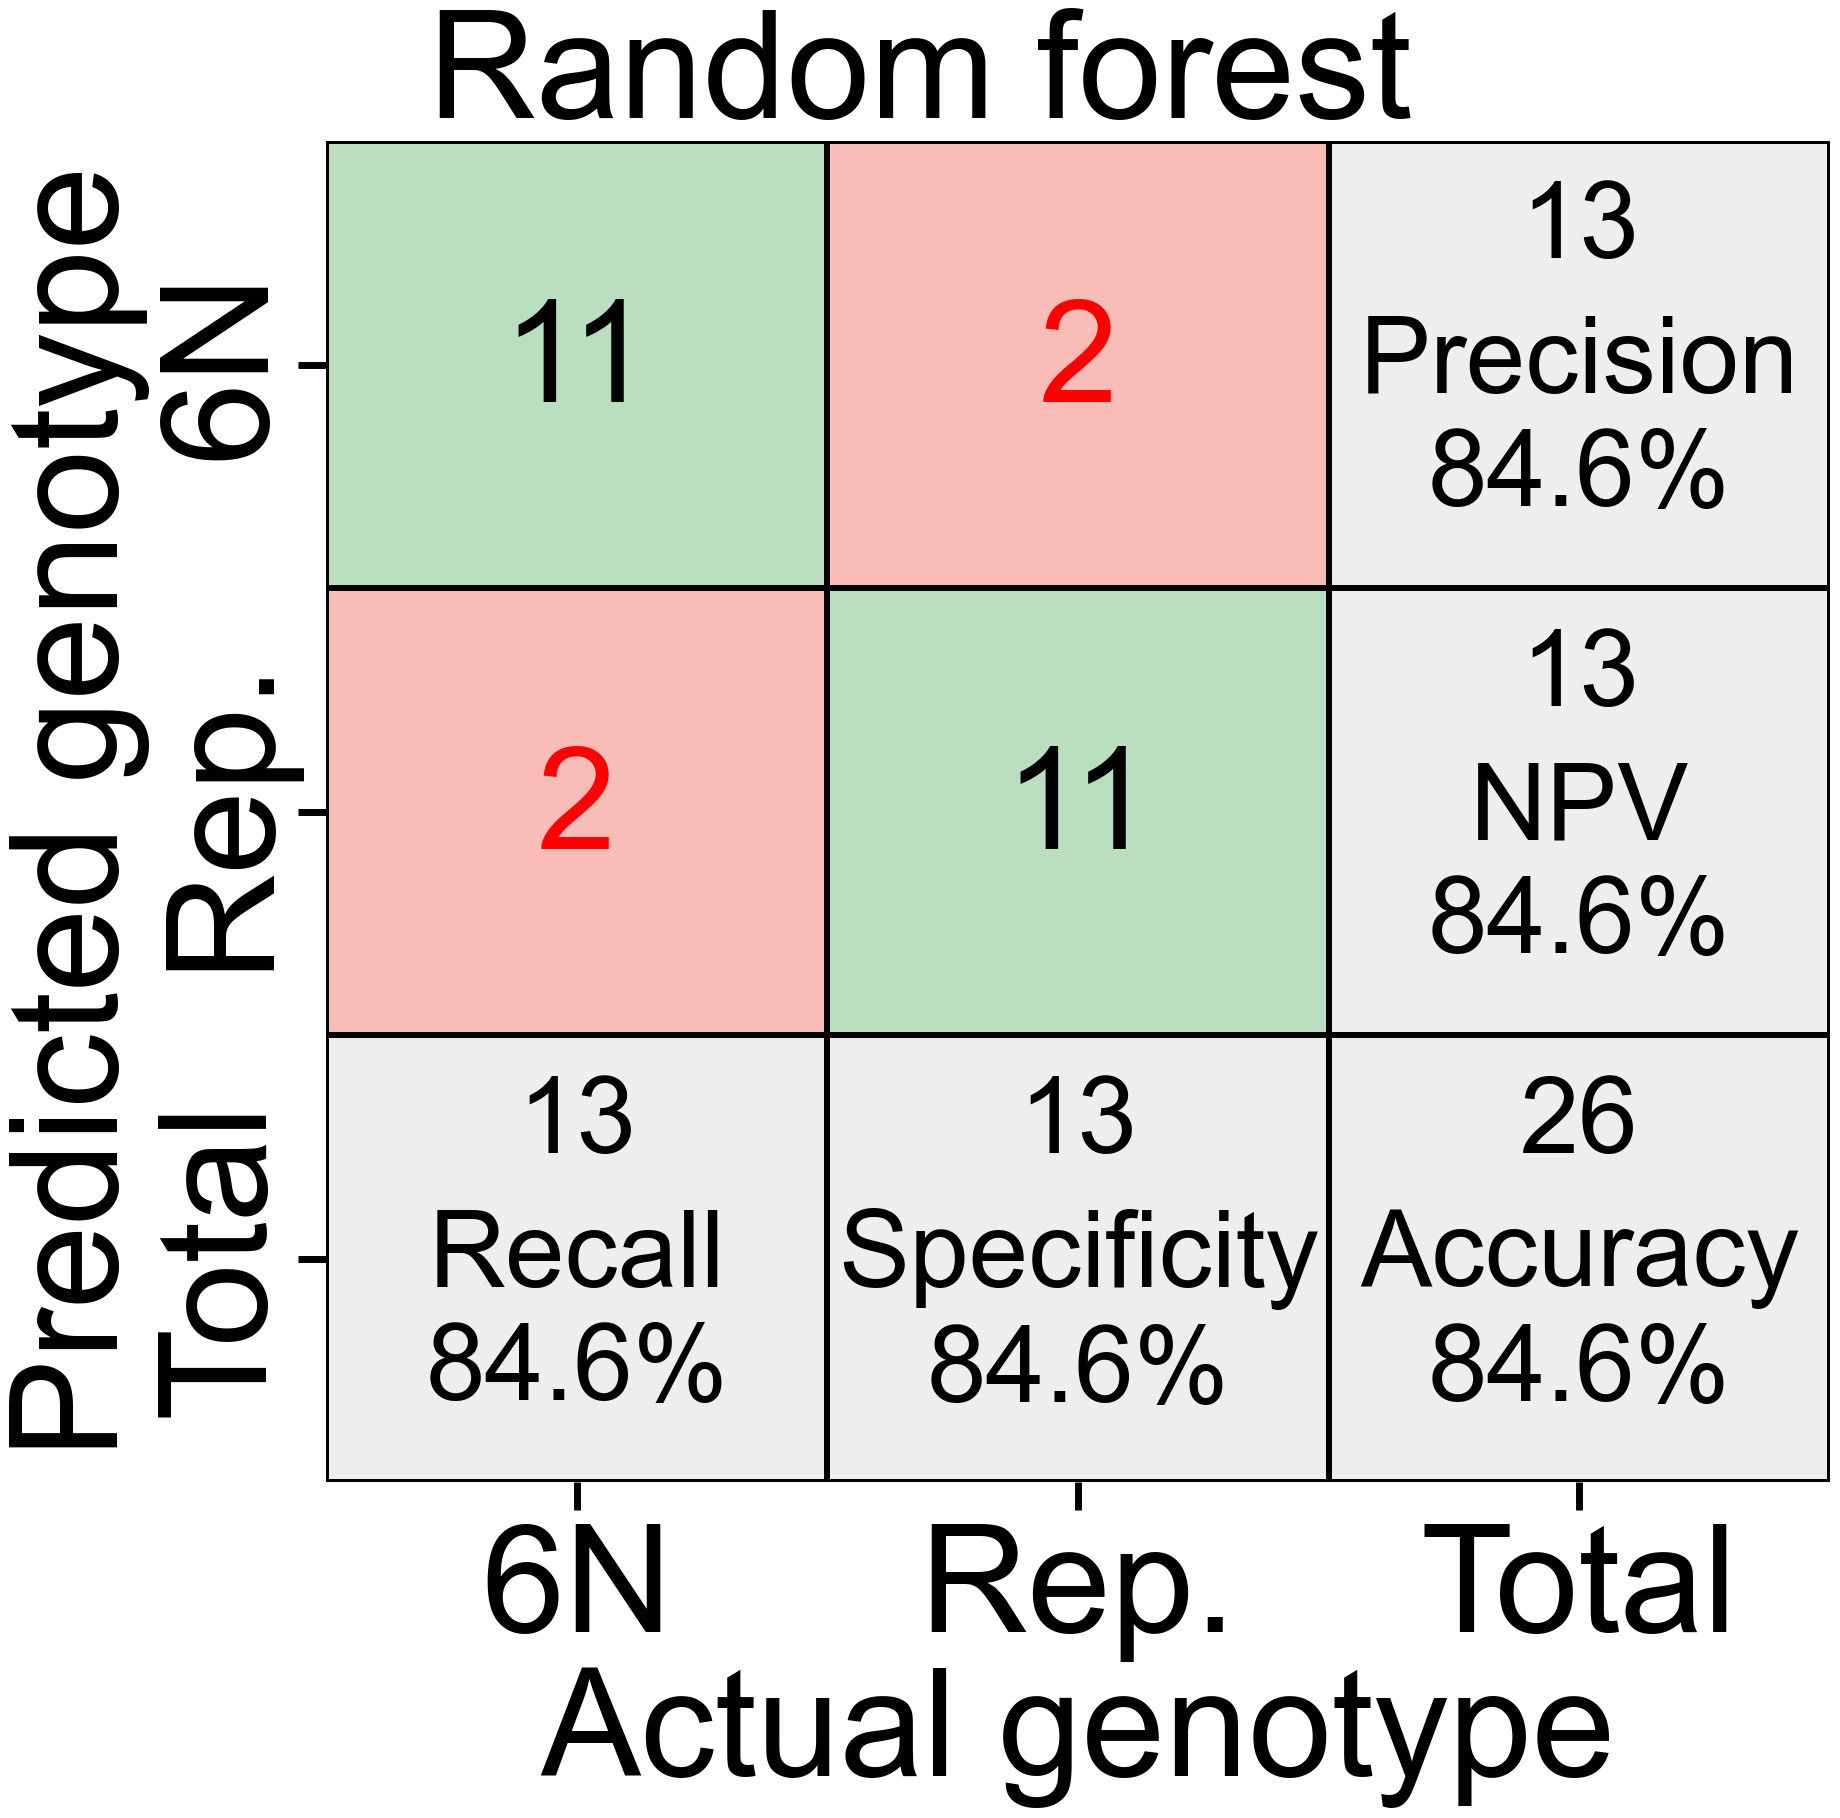

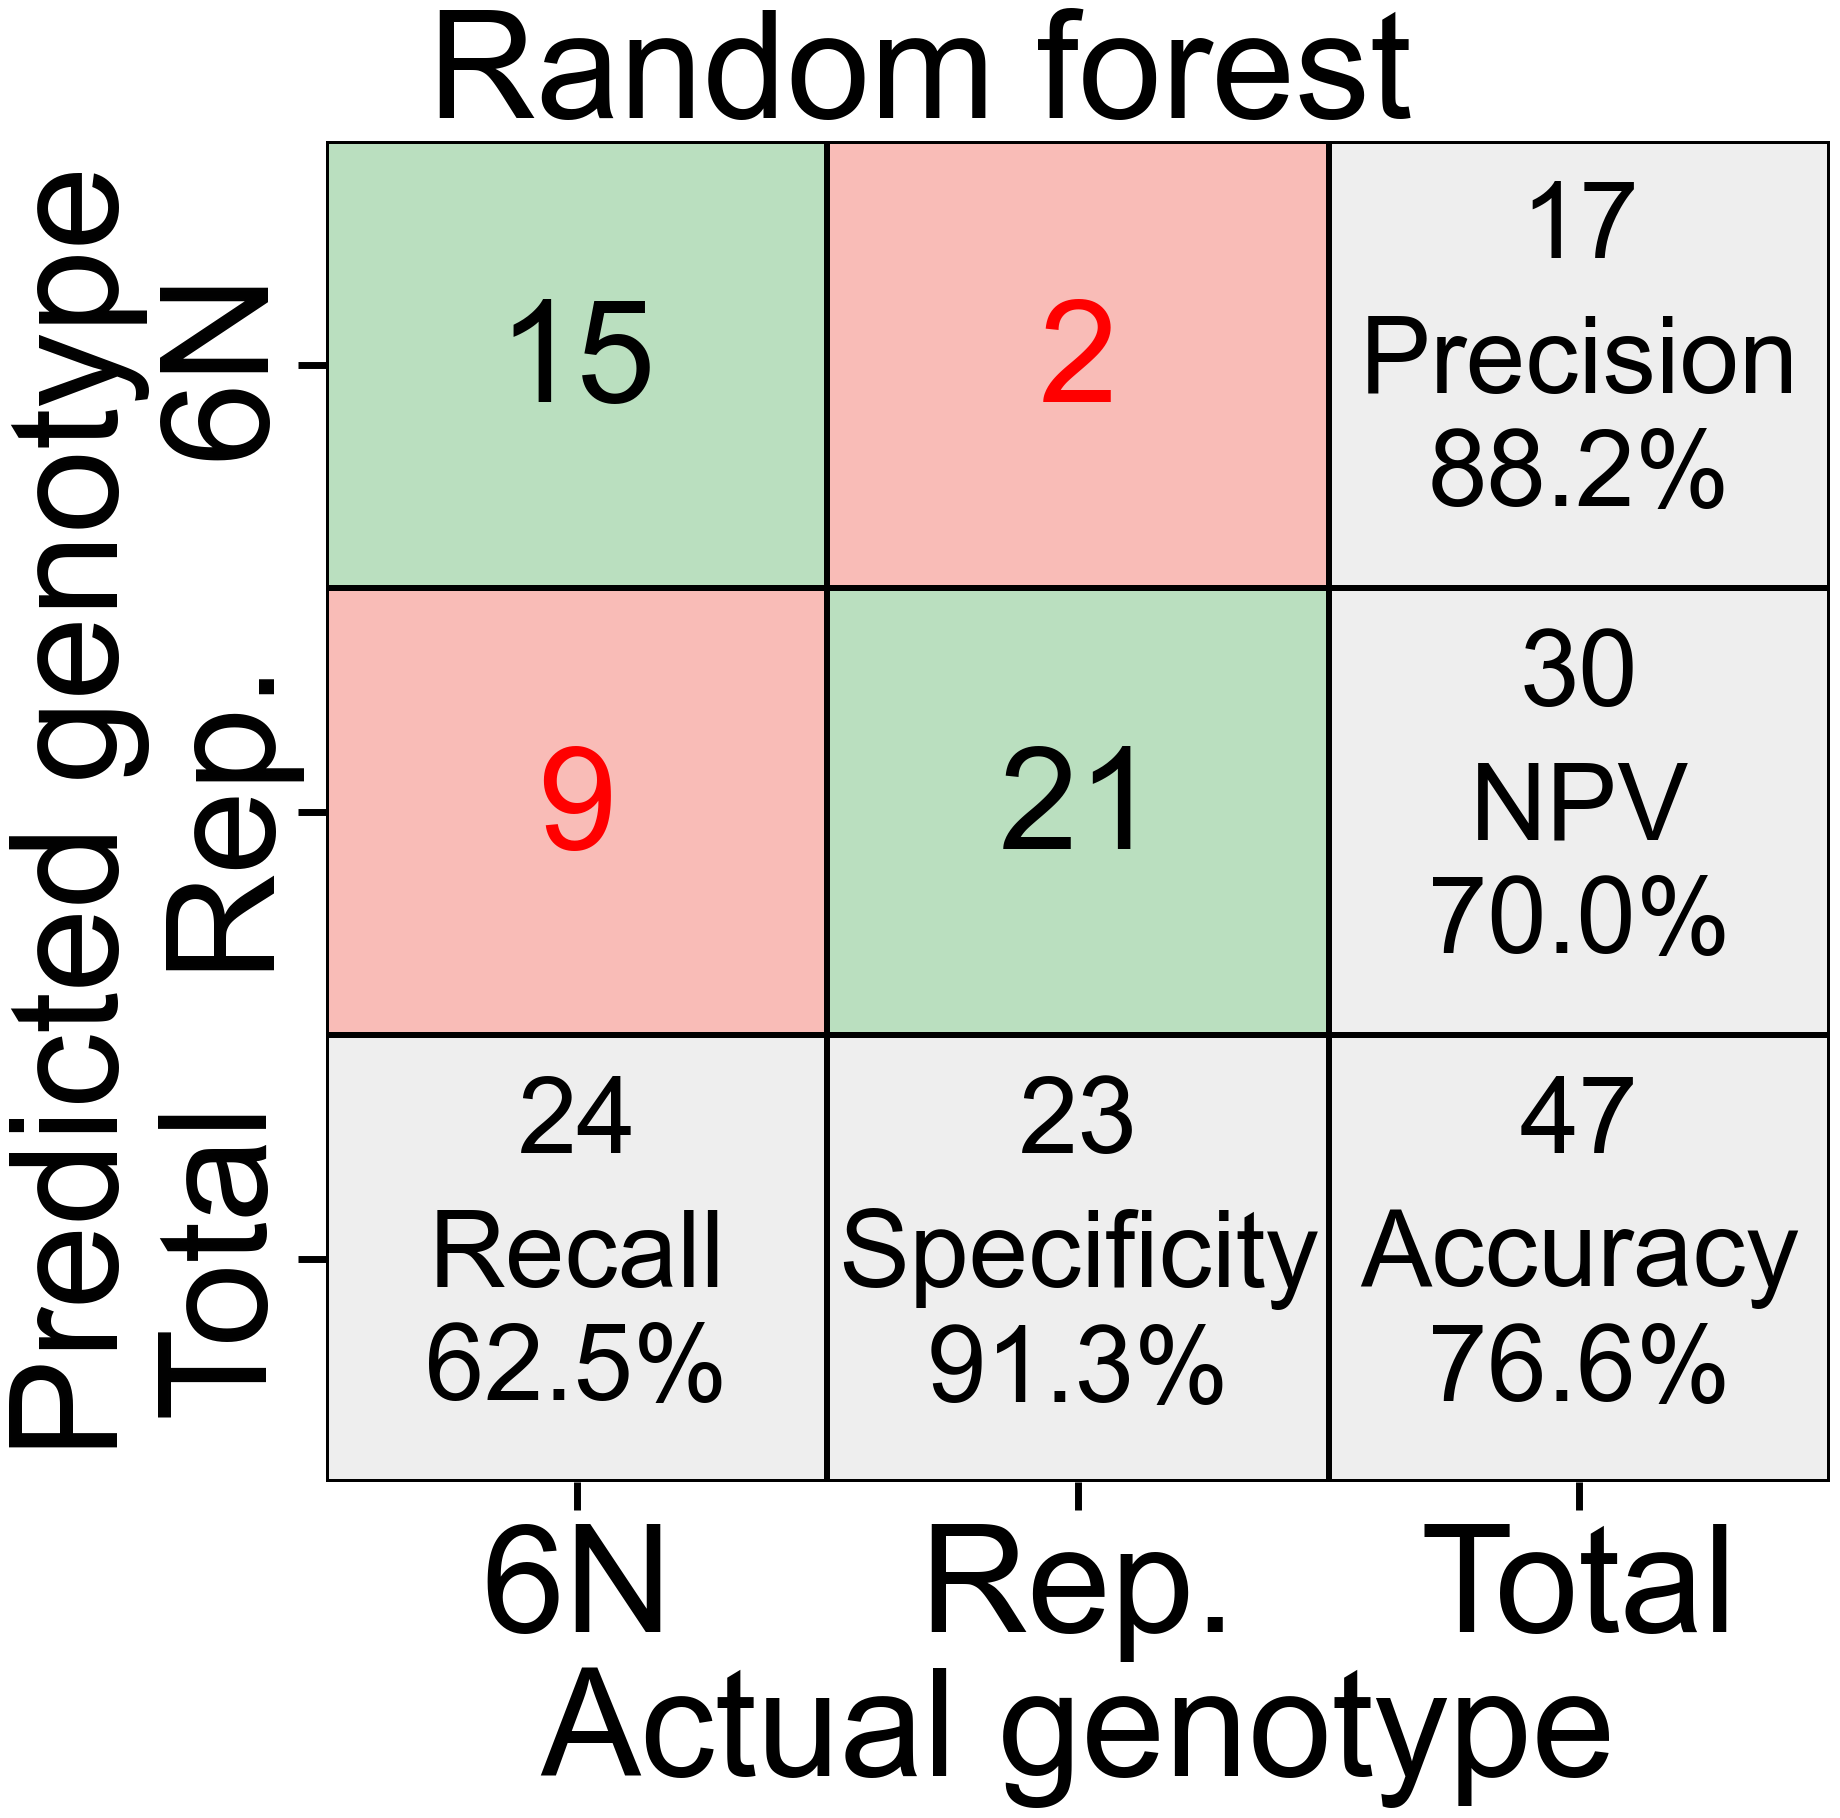

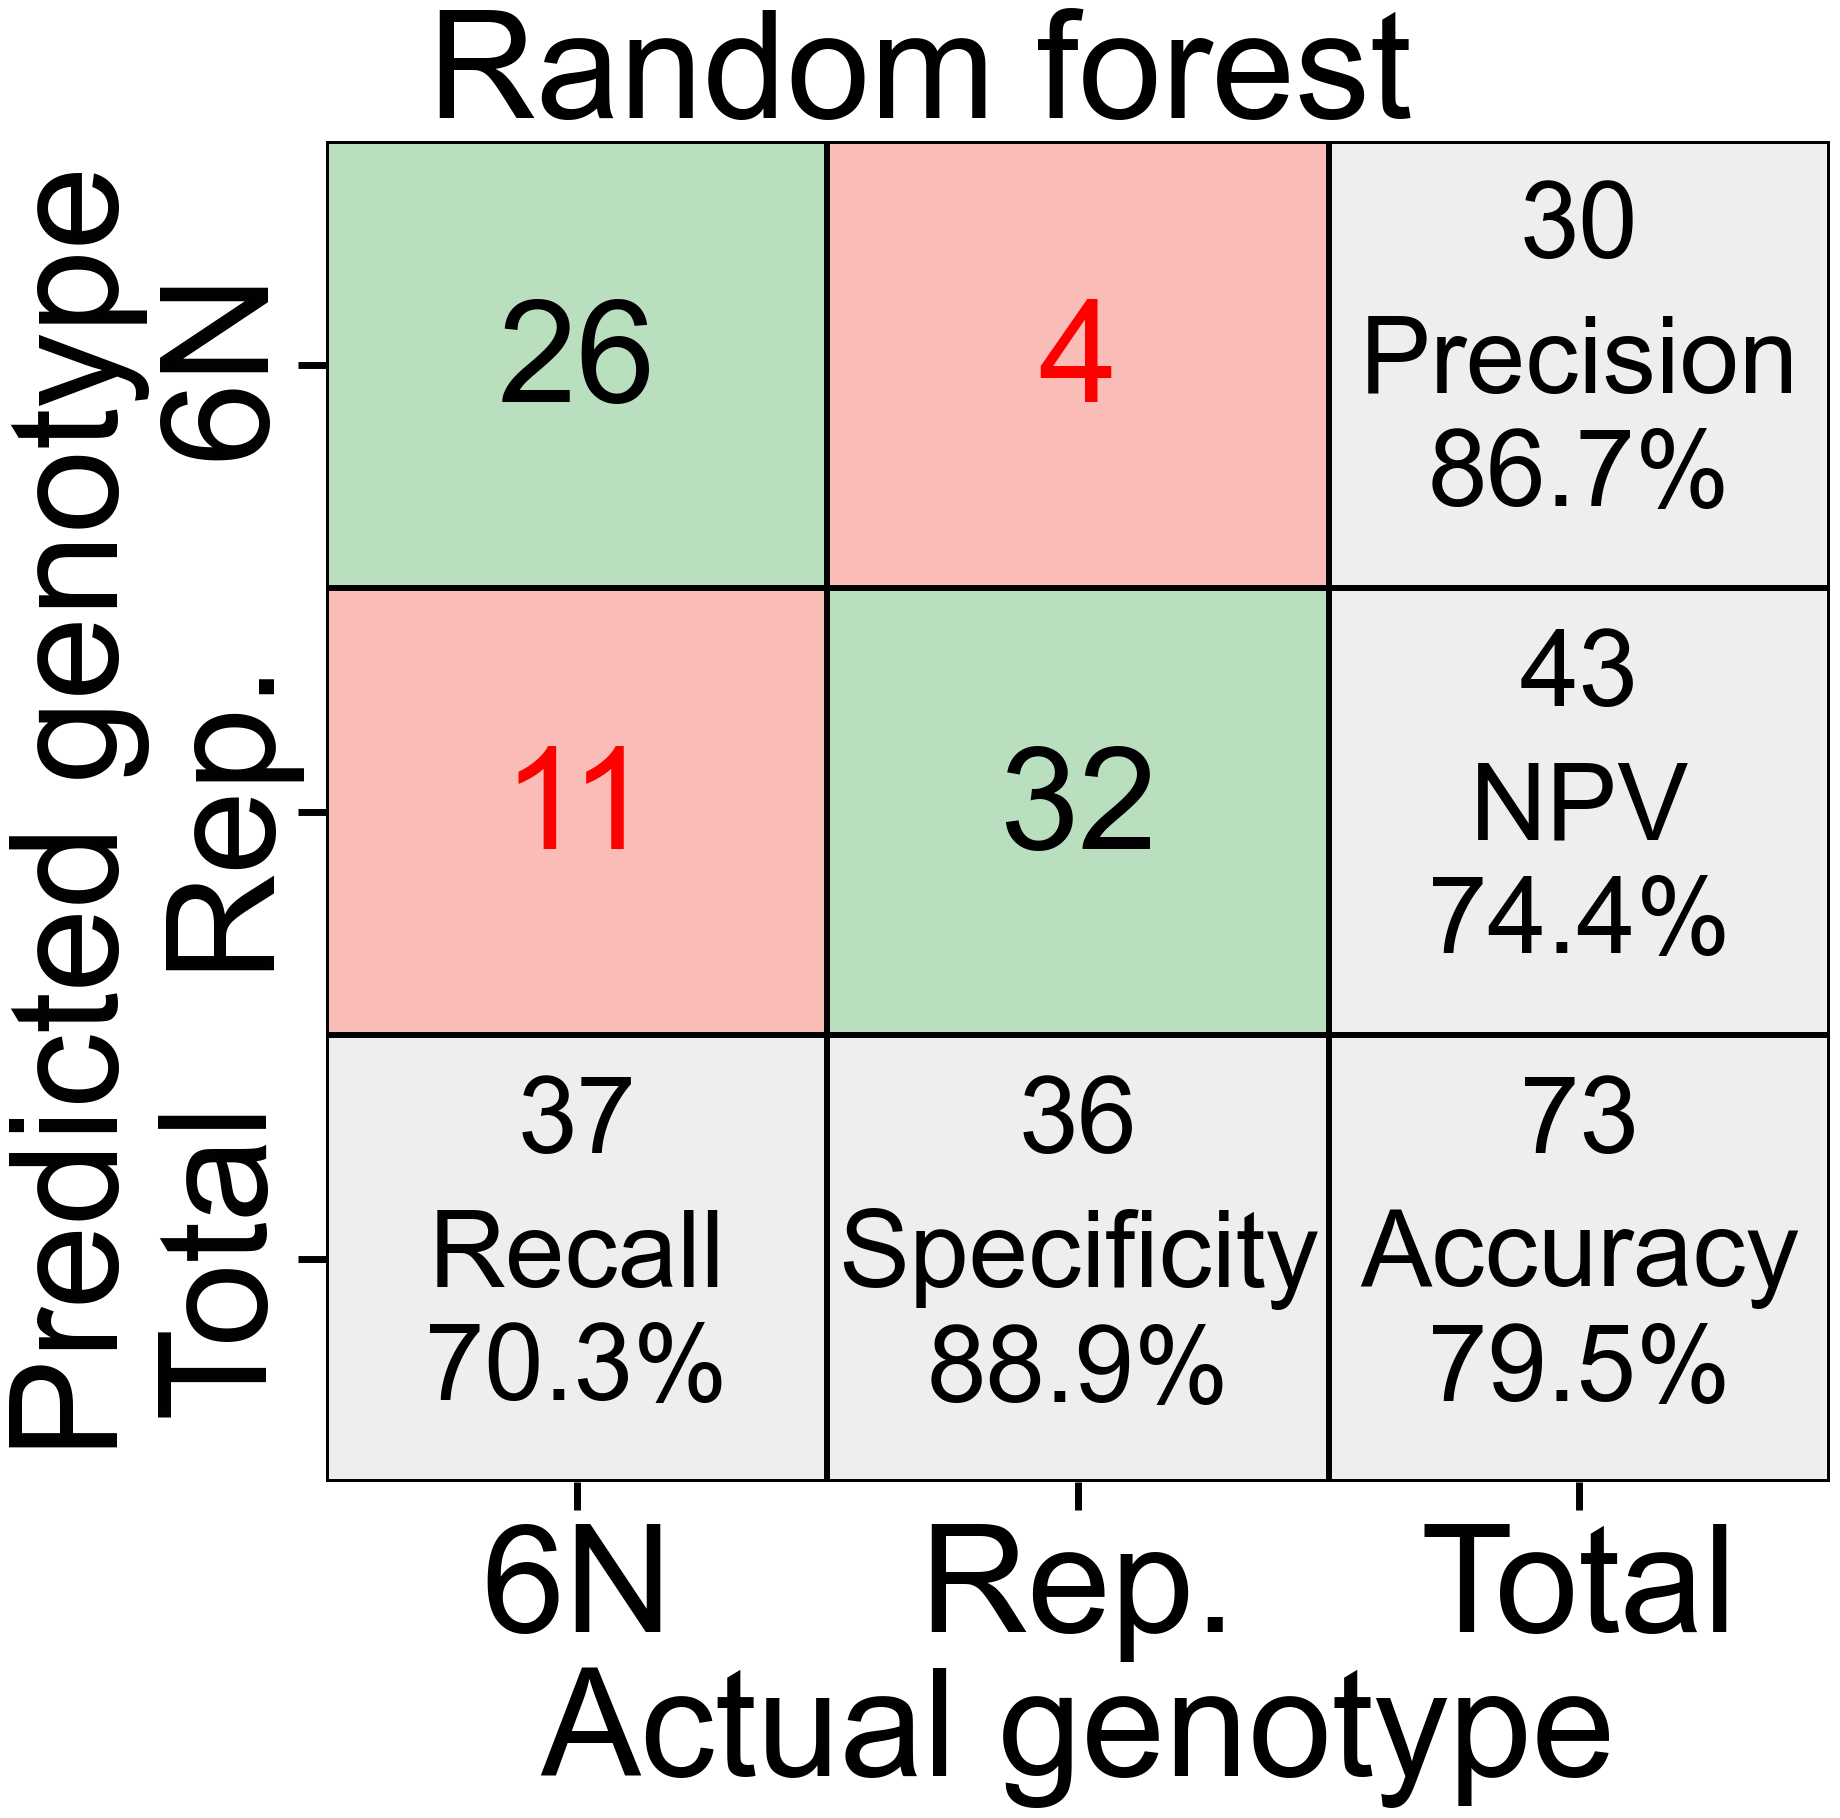

In [17]:
models = ['forest','SVC','MLP','XGBOOST','rocket','hivecote']
training = ['Sheffield', 'Kings','Combined']
targets = ['Sheffield', 'Kings','Combined']
index = 0

#SVC or ROCKET are the best for these data
for index in range(3):
    for model in [models[4]]:
        for target in targets:
            try:
                df = pd.read_csv(os.path.join(resultFolder,f'{model}{training[index]}_kFoldCrossValidation_AnovaFS10percentClicktestResults_{target}.csv'),index_col=0)
            except FileNotFoundError:
                try:
                    df = pd.read_csv(os.path.join(resultFolder,f'{model}{training[index]}_kFoldCrossValidation_AnovaFS10percentClicktestResults.csv'),index_col=0)
                except FileNotFoundError:
                    df = pd.read_csv(os.path.join(resultFolder,f'{model}{training[index]}_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
            y_test = df['y_test']
            y_predict = df['y_predict']
            fig = figureTools.makeConfMatrix(y_test,y_predict,f'',fontSize=fontSize,innerFontSize=54*1.9,figsize=(3.7*2.5*2,3.7*2.5*2))#train:{training[index]} test:{target}
            # ax = fig.gca()
            # ax.remove()
            # ax.figure = f
            # f.axes.append(ax)
            # f.add_axes(ax)
            # dummy_ax = f.add_subplot(331)
            # ax.set_position(dummy_ax.get_position())
            # dummy_ax.remove()
            fig.savefig(f'./Panels/CM_model_target{target}training{training[index]}__non_scaled.pdf',dpi=1200)

# Shapley coefficients

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def makeFigureFeatureImportanceSingleKings(h1,h2,out,fi,title,thresholds = None,fig=None,axs=None,linecolor = 'k',cmap=plt.cm.inferno,columns=np.arange(9),figsize=np.array([ 15.8/3 ,  16.35]), titleColor = 'k',plotDB=True):
    '''
    Make a figure from ABR trace data
    '''
    frequency = [h1[0]]#[100,3000,6000, 12000,18000,24000,30000,36000,42000 ]
    intensity = h2#arange(0,100,5)
    
    nint = len(intensity)
    
    nfreq=1
    freqmap=dict(zip(frequency,np.arange(len(frequency))))
    imap = dict(zip(intensity,np.arange(len(intensity))))

    ntraces = 153
    ppt = 1953 #points per trace
    

    if fig is None:
        fig,axs=plt.subplots(nint,nfreq,sharex=False, sharey=False,subplot_kw={'xticks': [], 'yticks': []},figsize=figsize)
    for i in range(len(intensity)):
        row = i#imap[int(h2[i])]

        #plotn = i+row*len(frequency)
        linecol = linecolor


        axs[nint-row-1].plot(out[i,2:],c=linecol,linewidth=2)

        if nint-row-1==0:
            tit1 = int(h1[i])

            if tit1 == 100:
                tit='Click'
            else:
                tit = str(int(tit1/1000))+' kHz'
            axs[nint-row-1].set_title(tit,fontsize=fontSize*0.55,ha='center')
        
        
        #axs[nint-row-1].set_ylabel(str(int(h2[i]))+' dB')
    
    

    for row in range(nint):
        tr = fi[(nint-1-row)*ppt:(nint-row)*ppt]
        currAx = row
        ax = fig.axes[currAx]
        divider = make_axes_locatable(ax)

        ax2 = divider.append_axes("bottom", size="100%", pad=-0.1, sharex=ax)
        #ax2.plot(tr,'r')
       # ax2.set_ylim(fi.min(),fi.max())
        ax2.imshow(tr.reshape((1,-1)),aspect=50,cmap=cmap,vmin=fi.min(),vmax=max(fi),alpha=1,interpolation='None')
        
            
    # ylims=(0,100)
    # for i in range(20,37):
    #     ax = fig.axes[i]
    #     ax.set_ylim(-0.1,0.1)
    #     ax.axis('off')
    
    plt.tight_layout()   
    for i in range(0,len(intensity)*2):
        ax = fig.axes[i]
    # ax.set_ylim(-4.5,7)
        ax.axis('off')
        ax.set_xlim(0,10*fs/1000)
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=0.05,hspace=0)


    #fig.text(0.08,0.95,'95',fontsize=28, rotation = 0,va='center',ha='center')fontsize=28*1.5
    if plotDB:
        fig.text(0.09,0.98,'dB',fontsize=fontSize*0.45, rotation = 0,va='center',ha='center')
        step = (0.97-0.051)/nint*1.03
        for i in range(nint):
            fig.text(0.08,0.051+i*step,f'{15+5*i}',fontsize=fontSize*0.45, rotation = 0,va='center',ha='center')

    fig.suptitle(title,y=1.015,fontsize=fontSize*0.45,weight='bold',color = titleColor)
    

    return fig,axs

In [19]:
from abrTools import loadKingsData, loadSheffieldData,interFunc


In [25]:
from matplotlib.colors import LinearSegmentedColormap


colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0, 0), (0,0,0)]  # white to light red to red
positions = [0, 0.1, 0.75,1]  # faster transition by moving middle point closer to start
cmap = LinearSegmentedColormap.from_list("custom_reds", list(zip(positions, colors)))

/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1388: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Repaired' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kingsData.loc[kingsData['Status']=='Ahl-Repaired','Strain']='Repaired'


'[(100, 75), (100, 80), (100, 85)] not in index'
1
'[(100, 85)] not in index'
2
'[(100, 85)] not in index'
3
'[(100, 85)] not in index'
4
'[(100, 80), (100, 85)] not in index'
5
'[(100, 75), (100, 80), (100, 85)] not in index'
6


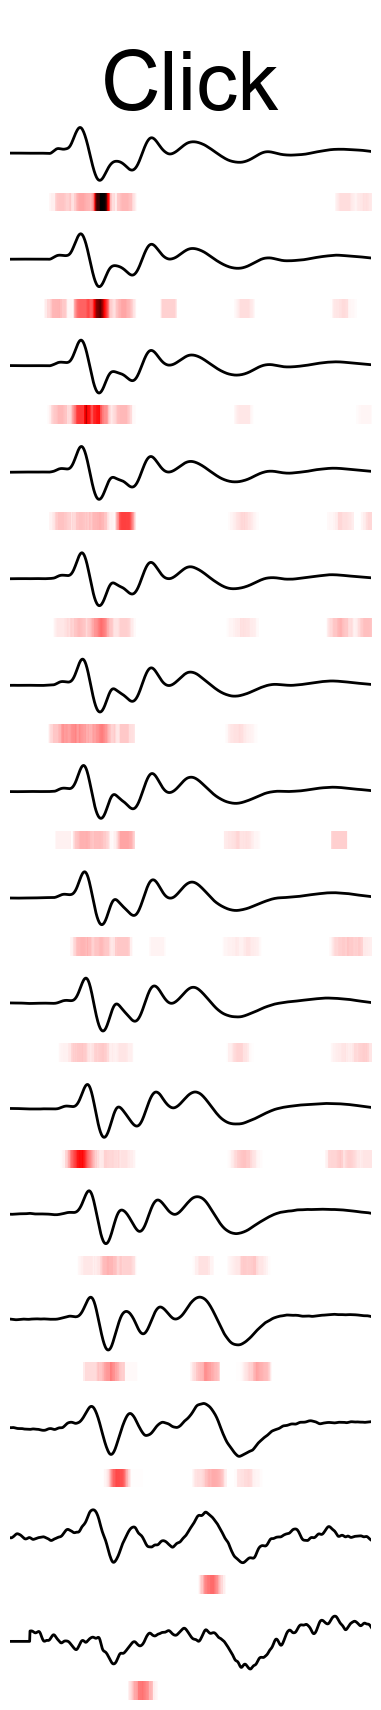

In [26]:
import joblib
savgolFilterOrder = 41
#cmap = cm.Reds


resultFolder =  '../../results/2024-10-27-sheffieldvKings-unscaled'

X_kings_train,X_kings_test,y_kings_train,y_kings_test,X_kings,y_kings = loadKingsData(shift=54,scaling=False,filename='../../data/Kings - MAchineLEarningABR_ExperimentList.xlsx',
                                                                                     dataFolder='../../data')
X = X_kings.mean(0)
X = pad(X,[54,0])
X = X.reshape(int(X.size/1953),1953)
h1 = array([100]*15)
h2 = arange(15,90,5)

#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forestKings_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)

fi2 = pd.read_csv(os.path.join(resultFolder,'XGBOOSTKings_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)

fi3 = pd.read_csv(os.path.join(resultFolder,'SVCKings_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)

# fi4 = pd.read_csv(os.path.join(resultFolder,'MLPKings_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
# fi4 = abs(fi3).mean(1).values
# fi4 = savgol_filter(fi4,savgolFilterOrder,1)

fi = (fi/fi.max()+fi2/fi2.max()+fi3/fi3.max())/3
fi = pad(fi,[54,0])
fig,axs = makeFigureFeatureImportanceSingleKings(h1,h2,np.hstack((h1.reshape(-1,1),h2.reshape(-1,1),X)),fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3.5 ,  17]),
                                                 titleColor = np.array([59,117,175])/255,plotDB=False)

fig.savefig('./Panels/ShapleyKingsVSheffield_Set2_Click_unscaled.pdf',dpi=1200,transparent=True)

The dataset version is: 20230914 - V41
Counter({'Repaired': 54, '6N': 50})


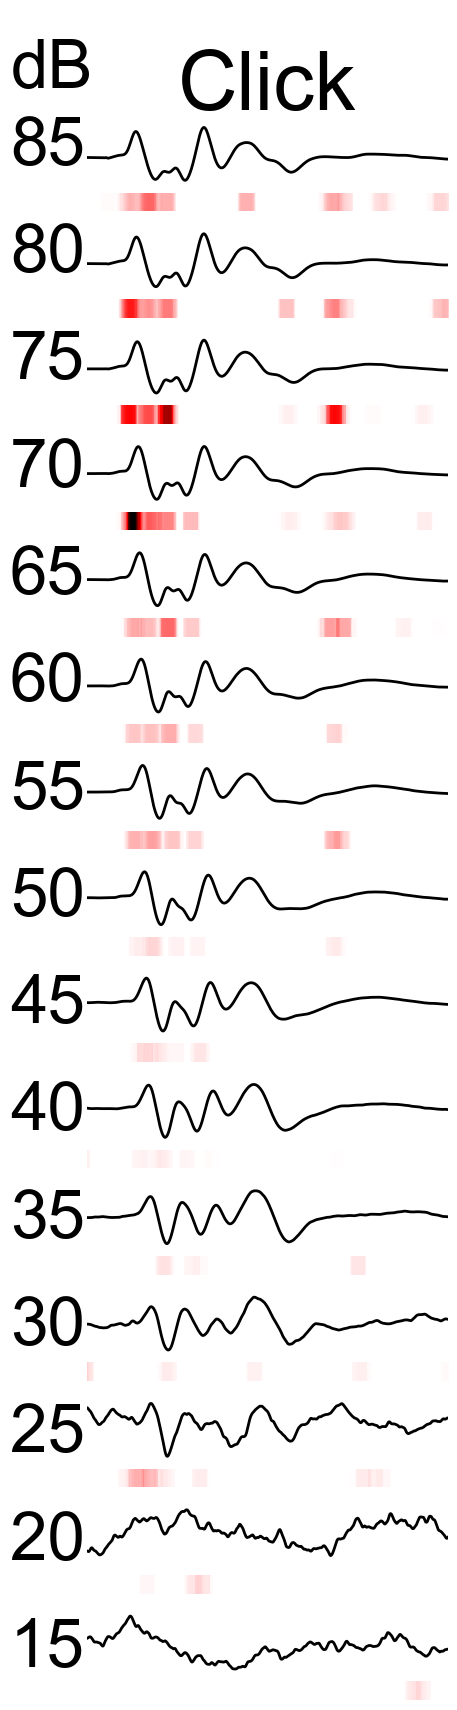

In [27]:
X_train_Sheffield,X_test_Sheffled,y_train_Sheffield,y_test_Sheffield,X_full,y_full, dataVersion = loadSheffieldData(shift=54,dataFolder='../../data')
X = X_full.mean(0)
X = pad(X,[0,54])
X = X.reshape(int(X.size/1953),1953)
h1 = array([100]*15)
h2 = arange(15,90,5)

#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forestSheffield_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)

fi2 = pd.read_csv(os.path.join(resultFolder,'XGBOOSTSheffield_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)

fi3 = pd.read_csv(os.path.join(resultFolder,'SVCSheffield_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)

# fi4 = pd.read_csv(os.path.join(resultFolder,'MLPSheffield_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
# fi4 = abs(fi3).mean(1).values
# fi4 = savgol_filter(fi4,savgolFilterOrder,1)

fi = (fi/fi.max()+fi2/fi2.max()+fi3/fi3.max())/3
fi = pad(fi,[0,54])
fig,axs = makeFigureFeatureImportanceSingleKings(h1,h2,np.hstack((h1.reshape(-1,1),h2.reshape(-1,1),X)),fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3.5 ,  17]),
                                                  titleColor = np.array([239,134,54])/255,plotDB=True)
fig.savefig('./Panels/ShapleyKingsVSheffield_Set1_Click_unscaled.pdf',dpi=1200,transparent=True)

/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1388: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Repaired' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kingsData.loc[kingsData['Status']=='Ahl-Repaired','Strain']='Repaired'


'[(100, 75), (100, 80), (100, 85)] not in index'
1
'[(100, 85)] not in index'
2
'[(100, 85)] not in index'
3
'[(100, 85)] not in index'
4
'[(100, 80), (100, 85)] not in index'
5
'[(100, 75), (100, 80), (100, 85)] not in index'
6
The dataset version is: 20230914 - V41
Counter({'Repaired': 54, '6N': 50})


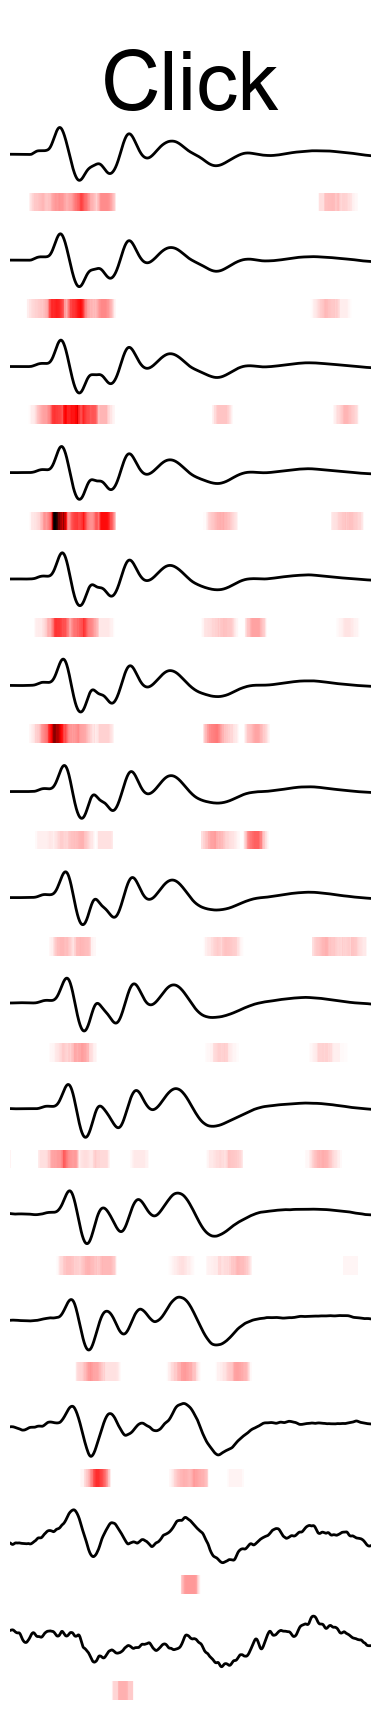

In [28]:
X_kings_train,X_kings_test,y_kings_train,y_kings_test,X_kings,y_kings = loadKingsData(shift=54,scaling=False,filename='../../data/Kings - MAchineLEarningABR_ExperimentList.xlsx',
                                                                                     dataFolder='../../data')

X_train_Sheffield,X_test_Sheffled,y_train_Sheffield,y_test_Sheffield,X_full,y_full, dataVersion = loadSheffieldData(shift=54,dataFolder='../../data')


X_train = np.vstack((X_train_Sheffield,X_kings_train))
X_test = np.vstack((X_test_Sheffled,X_kings_test))
y_train = np.hstack((y_train_Sheffield, y_kings_train))
y_test = np.hstack((y_test_Sheffield, y_kings_test))

X_combined = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))


X = X_combined.mean(0)
X = pad(X,[0,54])
X = X.reshape(int(X.size/1953),1953)
h1 = array([100]*15)
h2 = arange(15,90,5)


#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forestCombined_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)

fi2 = pd.read_csv(os.path.join(resultFolder,'XGBOOSTCombined_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)

fi3 = pd.read_csv(os.path.join(resultFolder,'SVCCombined_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)

# fi4 = pd.read_csv(os.path.join(resultFolder,'MLPCombined_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
# fi4 = abs(fi3).mean(1).values
# fi4 = savgol_filter(fi4,savgolFilterOrder,1)

fi = (fi/fi.max()+fi2/fi2.max()+fi3/fi3.max())/3
fi = pad(fi,[0,54])

fig,axs = makeFigureFeatureImportanceSingleKings(h1,h2,np.hstack((h1.reshape(-1,1),h2.reshape(-1,1),X)),fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3.5 ,  17]),
                                               titleColor =  np.array([81,158,62])/255,plotDB=False)

fig.savefig('./Panels/ShapleyKingsVSheffield_Combined_Click_unscaled.pdf',dpi=1200,transparent=True)

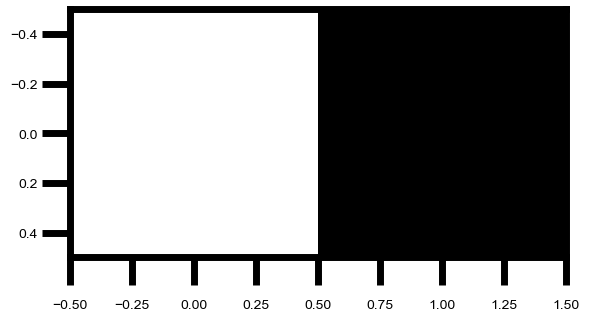

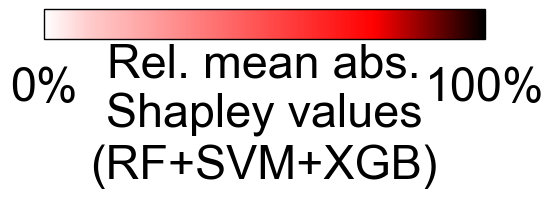

In [29]:
from matplotlib.colors import LinearSegmentedColormap


colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0, 0), (0,0,0)]  # white to light red to red
positions = [0, 0.1, 0.75,1]  # faster transition by moving middle point closer to start
cmap = LinearSegmentedColormap.from_list("custom_reds", list(zip(positions, colors)))
a = np.array([[0,1]])


img = imshow(a, cmap=cmap)
f=figure(figsize=(15.8/2.8 ,3.7*2.5*1.2))
gs= gridspec.GridSpec(2,1,height_ratios=[30,1],hspace=0,figure=f)
#ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])



colorbar(orientation="horizontal", cax=ax2,mappable=img)
ax2.set_xticks([0,1],['0%','100%'])
ax2.set_xlabel('Rel. mean abs.\nShapley values\n(RF+SVM+XGB)',rotation=0, va='center')
# for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
#             ax1.get_xticklabels() + ax1.get_yticklabels()):
#     item.set_fontsize(28)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(28*1.2)
ax2.xaxis.set_tick_params(width=0,length=10,color='w')
[i.set_linewidth(1) for i in ax2.spines.values()]

#ax2.set_frame_on(False)
gs.tight_layout(f)

f.savefig('./Panels/KingsVSheffieldColorbar.pdf',dpi=1200,transparent=True)